# Library Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt

# Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error, r2_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from scipy.stats import norm
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Anomaly Detection (advanced)
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.cof import COF
from pyod.utils.utility import standardizer

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
day_main = pd.read_csv('day.csv')
hour_main = pd.read_csv('hour.csv')
capitalDC_main = pd.read_csv('capital_dc.csv')
day_main['dteday'] = pd.to_datetime(day_main['dteday'])
hour_main['dteday'] = pd.to_datetime(hour_main['dteday'])
capitalDC_main['Start date'] = pd.to_datetime(capitalDC_main['Start date'])
capitalDC_main['End date'] = pd.to_datetime(capitalDC_main['End date'])

In [4]:
day = day_main.copy()
hour= hour_main.copy()
capitalDC = capitalDC_main.copy()

In [5]:
# Quick info
print(day.info())
print(hour.info())
print(capitalDC.info())

# Check for missing values
print(day.isna().sum())
print(hour.isna().sum())
print(capitalDC.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

In [6]:
print(day['dteday'].min(), "→", day['dteday'].max())
print(hour['dteday'].min(), "→", hour['dteday'].max())
print(capitalDC['Start date'].min(), "→", capitalDC['End date'].max())

2011-01-01 00:00:00 → 2012-12-31 00:00:00
2011-01-01 00:00:00 → 2012-12-31 00:00:00
2011-01-01 00:01:29 → 2013-01-01 02:15:29


In [7]:
capitalDC = capitalDC[(capitalDC['Start date'] >= '2011-01-01') &  (capitalDC['End date'] <= '2012-12-31 23:59:59')]

In [8]:
print(day['dteday'].min(), "→", day['dteday'].max())
print(hour['dteday'].min(), "→", hour['dteday'].max())
print(capitalDC['Start date'].min(), "→", capitalDC['End date'].max())

2011-01-01 00:00:00 → 2012-12-31 00:00:00
2011-01-01 00:00:00 → 2012-12-31 00:00:00
2011-01-01 00:01:29 → 2012-12-31 23:59:11


In [9]:
# Creating date feature by extracting dteday feature and then removing it from day and hour dataframe.
# If due to some analysis requirement we need dteday to be the index, then we might have to run the df load again and not run this section.
day['date'] = (day['dteday'] - day['dteday'].min()).dt.days
hour['date'] = (hour['dteday'] - hour['dteday'].min()).dt.days
day.info()
hour.info()
day = day.drop(columns=['dteday'])
hour = hour.drop(columns=['dteday'])
day.info()
hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
 16  date        731 non-null  

In [10]:
# droping instant from day and hour
# day = day.drop(columns=['instant'])
# hour = hour.drop(columns=['instant'])

In [11]:
# Preparing the dataset for PCA. He we will remove the target variable registered, casual and cnt from both dataset day and hour.
f_day = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'date']  # 12 numerical feature
f_hr = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'date'] # 13 numerical feature

#### Expected explained variance
- PC1	~35–40% (temperature, atemp, season patterns)
- PC2	~20–25% (humidity, windspeed, workingday)
#- PC3	~10–15% (weather + residuals)

    Component  ExplainedVariance  CumulativeVariance
0           1           0.243221            0.243221
1           2           0.151109            0.394330
2           3           0.139242            0.533572
3           4           0.109142            0.642714
4           5           0.097645            0.740359
5           6           0.081320            0.821679
6           7           0.075769            0.897448
7           8           0.061546            0.958995
8           9           0.026323            0.985318
9          10           0.013955            0.999273
10         11           0.000656            0.999928
11         12           0.000072            1.000000


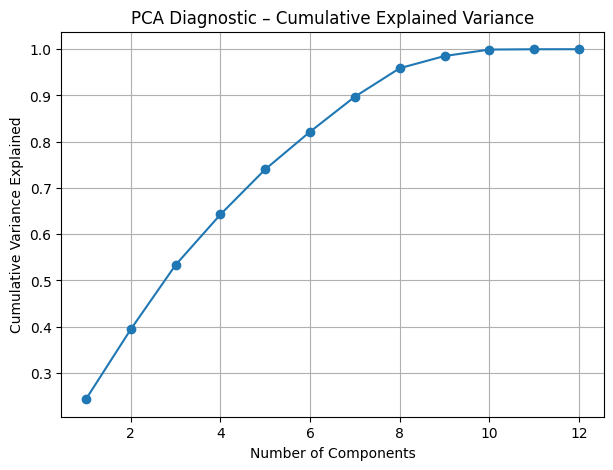

To retain at least 95% variance, keep 8 components.


In [12]:
# PCA evaluation for days
# Standardize
X_dayscale = StandardScaler().fit_transform(day[f_day])

# Diagnostic PCA
pca_day = PCA()
pca_day.fit(X_dayscale)

# Explained variance
explained = pca_day.explained_variance_ratio_
cumulative = np.cumsum(explained)

# Summary table
pca_summary = pd.DataFrame({
    'Component': np.arange(1, len(explained)+1),
    'ExplainedVariance': explained,
    'CumulativeVariance': cumulative
})
print(pca_summary)

# Plot
plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained)+1), cumulative, marker='o')
plt.title('PCA Diagnostic – Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

# Decision guideline
threshold = np.argmax(cumulative >= 0.95) + 1
print(f"To retain at least 95% variance, keep {threshold} components.")

    Component  ExplainedVariance  CumulativeVariance
0           1           0.211769            0.211769
1           2           0.143978            0.355747
2           3           0.130370            0.486117
3           4           0.100163            0.586280
4           5           0.089521            0.675801
5           6           0.081898            0.757699
6           7           0.074271            0.831970
7           8           0.063877            0.895847
8           9           0.056797            0.952644
9          10           0.033294            0.985938
10         11           0.013113            0.999051
11         12           0.000882            0.999933
12         13           0.000067            1.000000


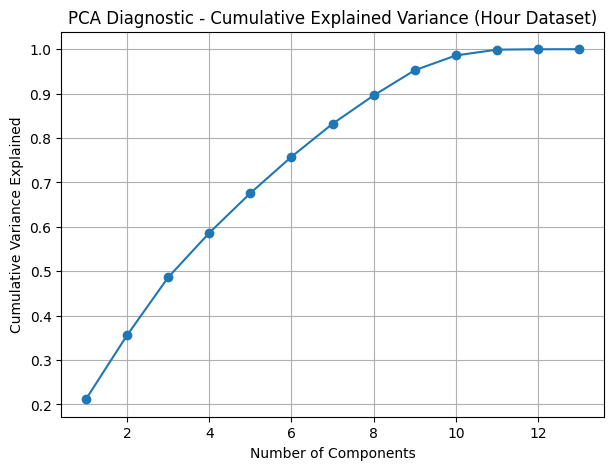

To retain at least 95% variance, keep 9 components.


In [13]:
# PCA evaluation for hour
# Standardize hour features
X_hrscale = StandardScaler().fit_transform(hour[f_hr])

# Diagnostic PCA
pca_hr = PCA()
pca_hr.fit(X_hrscale)

# Explained variance
explained_hr = pca_hr.explained_variance_ratio_
cumulative_hr = np.cumsum(explained_hr)

# Summary table
pca_hr_summary = pd.DataFrame({
    'Component': np.arange(1, len(explained_hr)+1),
    'ExplainedVariance': explained_hr,
    'CumulativeVariance': cumulative_hr
})
print(pca_hr_summary)

# Plot cumulative variance
plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained_hr)+1), cumulative_hr, marker='o')
plt.title('PCA Diagnostic - Cumulative Explained Variance (Hour Dataset)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

# Decision guideline for 95% variance
threshold_hr = np.argmax(cumulative_hr >= 0.95) + 1
print(f"To retain at least 95% variance, keep {threshold_hr} components.")


In [14]:
# Prepare PCA dataframe with suggested variance components
# Standardize features
X_dayscale = StandardScaler().fit_transform(day[f_day])
X_hrscale = StandardScaler().fit_transform(hour[f_hr])

# Determine number of components
n_day = np.argmax(np.cumsum(PCA().fit(X_dayscale).explained_variance_ratio_) >= 0.95) + 1
n_hr  = np.argmax(np.cumsum(PCA().fit(X_hrscale).explained_variance_ratio_) >= 0.95) + 1

# Fit PCA with selected components
pca_day = PCA(n_components=n_day)
day_pca_transformed = pca_day.fit_transform(X_dayscale)
pca_hr = PCA(n_components=n_hr)
hr_pca_transformed = pca_hr.fit_transform(X_hrscale)

# Create DataFrames with PCA components
day_pca_df = pd.DataFrame(day_pca_transformed,columns=[f'PC{i+1}' for i in range(n_day)])
hr_pca_df = pd.DataFrame(hr_pca_transformed,columns=[f'PC{i+1}' for i in range(n_hr)])

print(f"Day PCA DataFrame shape: {day_pca_df.shape}")
print(f"Hour PCA DataFrame shape: {hr_pca_df.shape}")

Day PCA DataFrame shape: (731, 8)
Hour PCA DataFrame shape: (17379, 9)


In [15]:
# Listing featuers weight in each PCA component
# Day dataset
loadings_day = pd.DataFrame(pca_day.components_.T,  # transpose: features x components
                            index=f_day,             # original feature names
                            columns=[f'PC{i+1}' for i in range(pca_day.n_components_)])

print("Day PCA Loadings:")
print(loadings_day)

# Hour dataset
loadings_hr = pd.DataFrame(pca_hr.components_.T,
                           index=f_hr,
                           columns=[f'PC{i+1}' for i in range(pca_hr.n_components_)])
print("\nHour PCA Loadings:")
print(loadings_hr)

Day PCA Loadings:
                 PC1       PC2       PC3       PC4       PC5       PC6  \
season     -0.461691 -0.061746  0.146013  0.186180 -0.380163 -0.017463   
yr         -0.178110  0.601267  0.120319 -0.243661  0.342567  0.011970   
mnth       -0.437731 -0.014041  0.239830  0.212097 -0.407553 -0.003991   
holiday     0.013359  0.081354  0.020821  0.606224  0.299171  0.147339   
weekday     0.005999  0.001102 -0.006441 -0.267633 -0.297177  0.846613   
workingday -0.029527 -0.092692 -0.014415 -0.589536 -0.207561 -0.367222   
weathersit -0.006292 -0.304933  0.526969 -0.194685  0.326404  0.175470   
temp       -0.410119 -0.181898 -0.450153 -0.090495  0.254775  0.103642   
atemp      -0.415548 -0.187086 -0.444324 -0.087287  0.253014  0.089318   
hum        -0.181934 -0.418570  0.417598 -0.068869  0.326120  0.018157   
windspeed   0.222766  0.134394 -0.059380 -0.067881  0.021540  0.276251   
date       -0.372533  0.514705  0.224347 -0.105984  0.094031  0.008262   

                 PC

#### For Day PCA
- PC1 vs PC3 → main variation by weather & season
- PC2 vs PC4 → trend over year + holiday effects
- PC1 vs PC6 → season + weekday/weekend patterns

#### For Hour PCA
- PC1 vs PC2 → season + weather patterns
- PC1 vs PC6 → season + hourly usage pattern
- PC4 vs PC7 → holiday/weekend effect + weekday pattern

Day PCA:
Davies-Bouldin Score for k2: 1.858
Davies-Bouldin Score for k3: 1.923
Davies-Bouldin Score for k4: 1.968
Davies-Bouldin Score for k5: 1.880
Davies-Bouldin Score for k6: 1.808
Davies-Bouldin Score for k7: 1.488
Davies-Bouldin Score for k8: 1.470
Davies-Bouldin Score for k9: 1.512
Davies-Bouldin Score for k10: 1.422


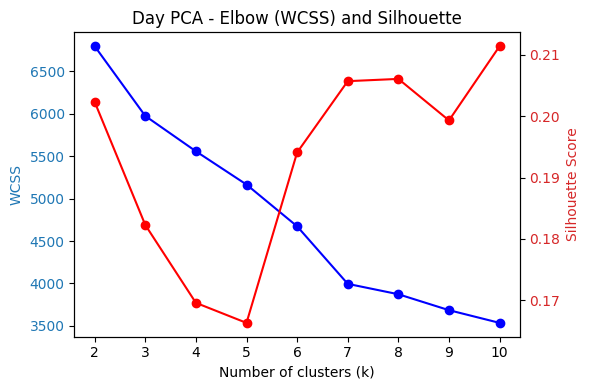

Hour PCA:
Davies-Bouldin Score for k2: 2.363
Davies-Bouldin Score for k3: 2.026
Davies-Bouldin Score for k4: 1.966
Davies-Bouldin Score for k5: 1.830
Davies-Bouldin Score for k6: 1.915
Davies-Bouldin Score for k7: 1.995
Davies-Bouldin Score for k8: 1.668
Davies-Bouldin Score for k9: 1.607
Davies-Bouldin Score for k10: 1.629


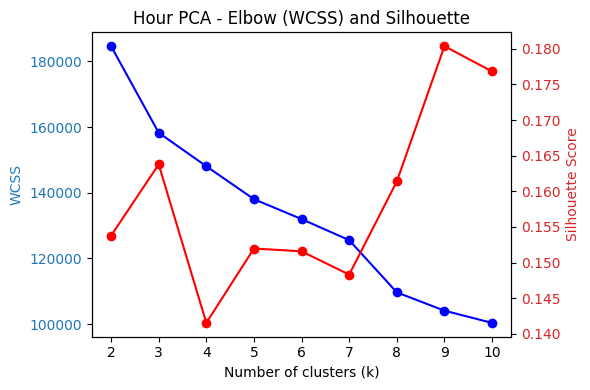

In [16]:
def elbow_silhouette_dualaxis(X, dataset_name='Dataset', max_k=10):
    k_range = list(range(2, max_k+1))
    wcss = []
    sil_scores = []

    print(f"{dataset_name}:")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X, labels))
        db_score = davies_bouldin_score(X, labels)
        print(f"Davies-Bouldin Score for k{k}: {db_score:.3f}")

    # Plot with dual y-axis
    fig, ax1 = plt.subplots(figsize=(6,4))

    color = 'tab:blue'
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('WCSS', color=color)
    ax1.plot(k_range, wcss, 'bo-', label='WCSS')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # Secondary y-axis for Silhouette
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(k_range, sil_scores, 'ro-', label='Silhouette')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'{dataset_name} - Elbow (WCSS) and Silhouette')
    fig.tight_layout()
    plt.show()

# Prepare PCA component arrays
X_day = day_pca_df[[col for col in day_pca_df.columns if 'PC' in col]].values
X_hr  = hr_pca_df[[col for col in hr_pca_df.columns if 'PC' in col]].values

# Plot for Day PCA
elbow_silhouette_dualaxis(X_day, dataset_name='Day PCA', max_k=10)

# Plot for Hour PCA
elbow_silhouette_dualaxis(X_hr, dataset_name='Hour PCA', max_k=10)


In [17]:
# Creating Cluster for Day
k_day = 6
kmeans_day = KMeans(n_clusters=k_day, random_state=42, n_init='auto')
day_pca_df['cluster'] = kmeans_day.fit_predict(day_pca_df)
# Evaluate
sil_day = silhouette_score(day_pca_df, day_pca_df['cluster'])
db_day = davies_bouldin_score(day_pca_df, day_pca_df['cluster'])
print(f"Day PCA → silhouette: {sil_day:.3f}, Davies-Bouldin: {db_day:.3f}")

# Creating Cluster for Hour
k_hour = 8
kmeans_day = KMeans(n_clusters=k_hour, random_state=42, n_init='auto')
hr_pca_df['cluster'] = kmeans_day.fit_predict(hr_pca_df)
# Evaluate
sil_hr = silhouette_score(hr_pca_df, hr_pca_df['cluster'])
db_hr = davies_bouldin_score(hr_pca_df, hr_pca_df['cluster'])
print(f"Hour PCA → silhouette: {sil_day:.3f}, Davies-Bouldin: {db_hr:.3f}")

Day PCA → silhouette: 0.282, Davies-Bouldin: 1.520
Hour PCA → silhouette: 0.282, Davies-Bouldin: 1.454


In [18]:
print(day_pca_df['cluster'].value_counts())
print(hr_pca_df['cluster'].value_counts())

cluster
3    164
5    142
2    112
1    112
0    111
4     90
Name: count, dtype: int64
cluster
0    3376
6    2842
3    2440
2    2293
4    2290
1    1823
7    1815
5     500
Name: count, dtype: int64


In [19]:
day_pca_df.head()
hr_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.147624  0.885872 -1.235789  0.361533  0.419426 -2.377992  1.856502   
1  3.223889  0.898901 -1.163650  0.386578  0.318003 -2.308422  1.824395   
2  3.217620  0.852660 -1.143174  0.392530  0.292461 -2.236443  1.813070   
3  3.143460  0.611694 -1.049890  0.410565  0.246766 -2.190326  1.801716   
4  3.137191  0.565453 -1.029414  0.416517  0.221225 -2.118347  1.790391   

        PC8       PC9  cluster  
0 -0.316809 -0.759892        4  
1 -0.435059 -0.758851        4  
2 -0.539241 -0.762689        4  
3 -0.620665 -0.756968        4  
4 -0.724846 -0.760806        4

In [20]:
# Adding features dteday, Registered, Casual and hr in respective dataframe

#day_pca_df = day_pca_df.merge(day_main[['dteday', 'registered', 'casual']],left_index=True, right_index=True)
#day_pca_df.rename(columns={'dteday': 'date'}, inplace=True)

#hr_pca_df = hr_pca_df.merge(hour_main[['dteday', 'hr', 'registered', 'casual']],left_index=True, right_index=True)
#hr_pca_df.rename(columns={'dteday': 'date'}, inplace=True)

In [21]:
day_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.496486 -1.899065  0.723321  0.057071  0.846668  1.751471 -1.385938   
1  2.852363 -1.432158  0.333588  0.829732  1.521705 -0.478246  0.563957   
2  3.925806  0.047149 -0.566896  0.081312 -0.753215 -1.386389  0.298570   
3  3.411973 -0.582729 -0.123120 -0.063719 -0.534290 -1.243655 -0.925860   
4  3.581714 -0.128729 -0.709095 -0.169393 -0.962252 -0.721033 -0.666030   

        PC8  cluster  
0 -0.852155        2  
1 -1.387314        2  
2  0.220239        2  
3  0.296588        2  
4  0.420803        2

In [22]:
hr_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.147624  0.885872 -1.235789  0.361533  0.419426 -2.377992  1.856502   
1  3.223889  0.898901 -1.163650  0.386578  0.318003 -2.308422  1.824395   
2  3.217620  0.852660 -1.143174  0.392530  0.292461 -2.236443  1.813070   
3  3.143460  0.611694 -1.049890  0.410565  0.246766 -2.190326  1.801716   
4  3.137191  0.565453 -1.029414  0.416517  0.221225 -2.118347  1.790391   

        PC8       PC9  cluster  
0 -0.316809 -0.759892        4  
1 -0.435059 -0.758851        4  
2 -0.539241 -0.762689        4  
3 -0.620665 -0.756968        4  
4 -0.724846 -0.760806        4

### Hierarchical CLustering

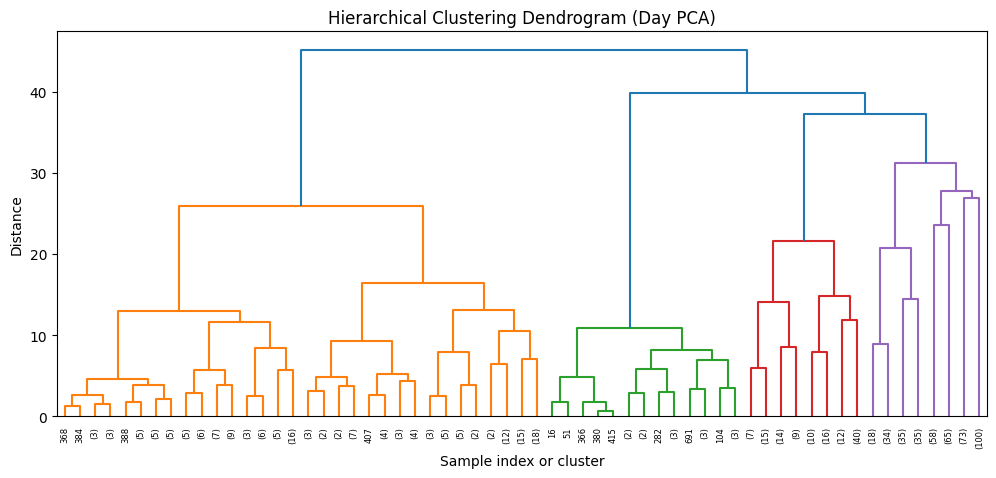

In [23]:
X_day_hc = day_pca_df[[col for col in day_pca_df.columns if 'PC' in col]].values

# Compute linkage matrix
Z_day = linkage(X_day_hc, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z_day, truncate_mode='level', p=5, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Day PCA)')
plt.xlabel('Sample index or cluster')
plt.ylabel('Distance')
plt.show()

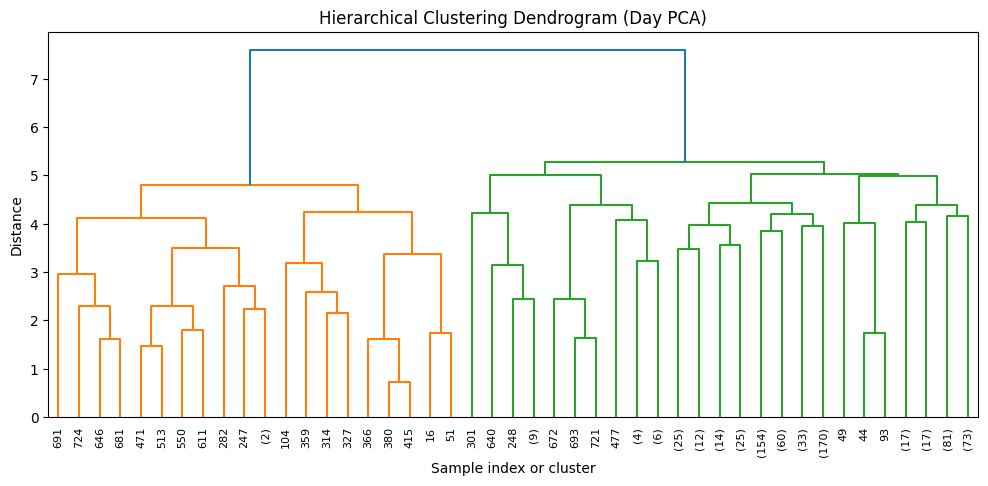

In [24]:
Z_day = linkage(X_day_hc, method='average')
plt.figure(figsize=(12, 5))
dendrogram(Z_day, truncate_mode='level', p=5, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Day PCA)')
plt.xlabel('Sample index or cluster')
plt.ylabel('Distance')
plt.show()

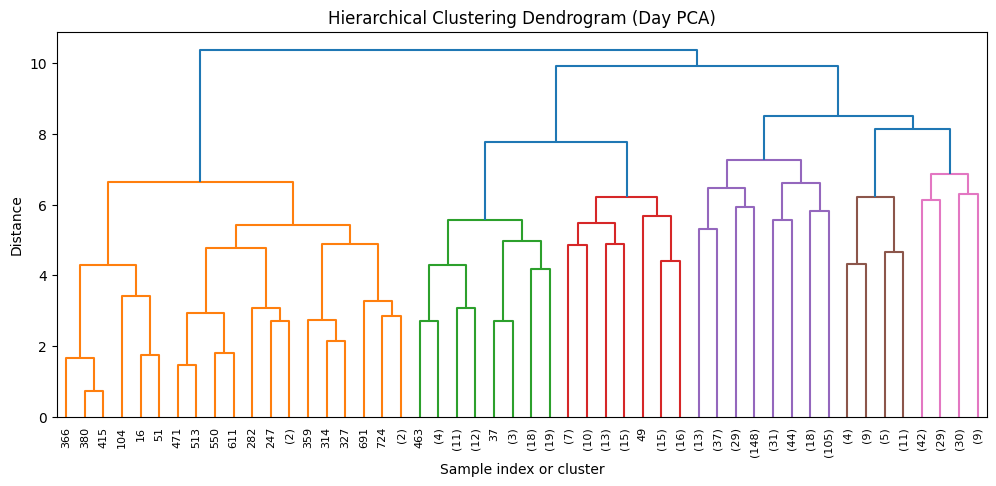

In [25]:
Z_day = linkage(X_day_hc, method='complete')
plt.figure(figsize=(12, 5))
dendrogram(Z_day, truncate_mode='level', p=5, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Day PCA)')
plt.xlabel('Sample index or cluster')
plt.ylabel('Distance')
plt.show()

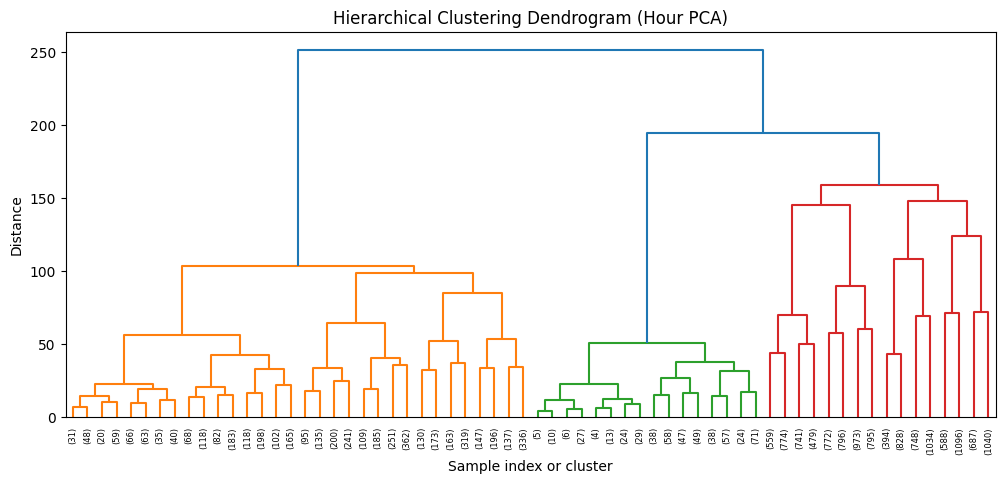

In [26]:
X_hr_hc = hr_pca_df[[col for col in hr_pca_df.columns if 'PC' in col]].values

# Compute linkage matrix
Z_hr = linkage(X_hr_hc, method='ward')

# Plot dendrogram (truncate for readability, sample if too large)
plt.figure(figsize=(12, 5))
dendrogram(Z_hr, truncate_mode='level', p=5, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Hour PCA)')
plt.xlabel('Sample index or cluster')
plt.ylabel('Distance')
plt.show()

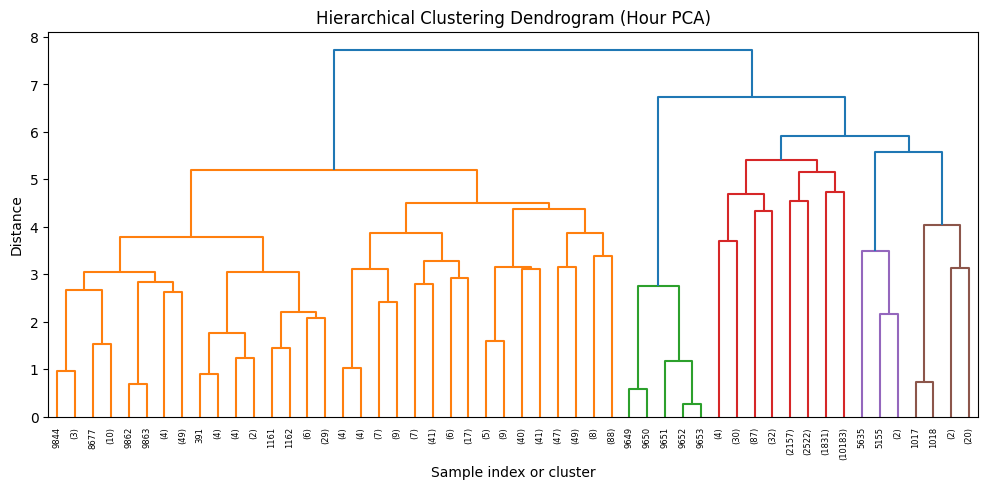

In [27]:
Z_hr = linkage(X_hr_hc, method='average')
plt.figure(figsize=(12, 5))
dendrogram(Z_hr, truncate_mode='level', p=5, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Hour PCA)')
plt.xlabel('Sample index or cluster')
plt.ylabel('Distance')
plt.show()

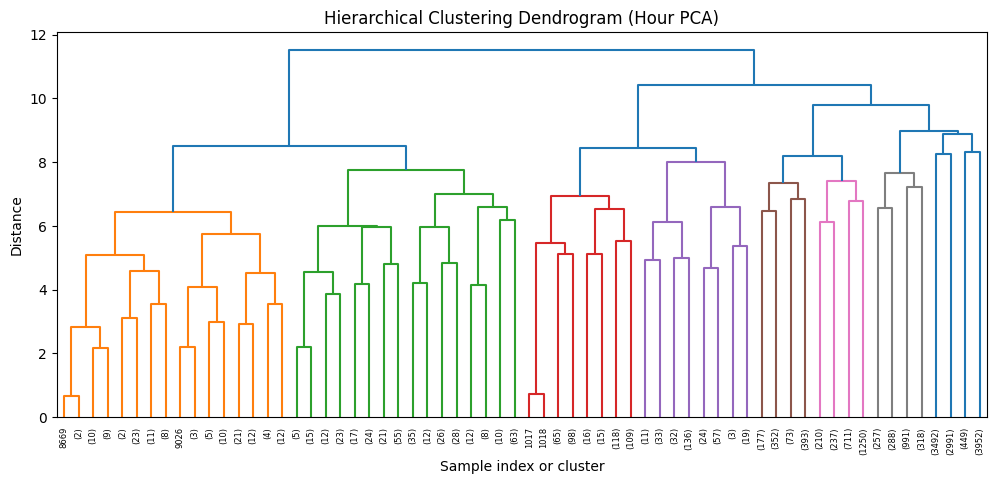

In [28]:
Z_hr = linkage(X_hr_hc, method='complete')
plt.figure(figsize=(12, 5))
dendrogram(Z_hr, truncate_mode='level', p=5, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Hour PCA)')
plt.xlabel('Sample index or cluster')
plt.ylabel('Distance')
plt.show()

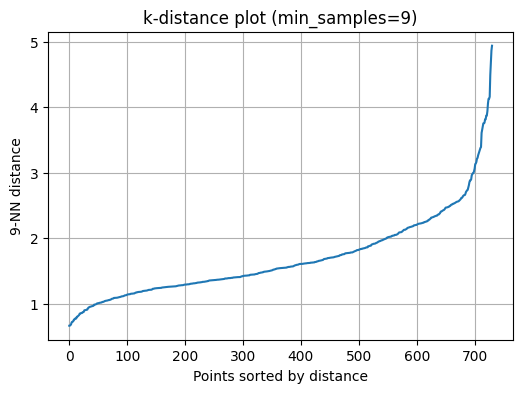

Suggested min_samples = 9
Estimate eps from the 'elbow' in the plot (sharp bend in distance curve).


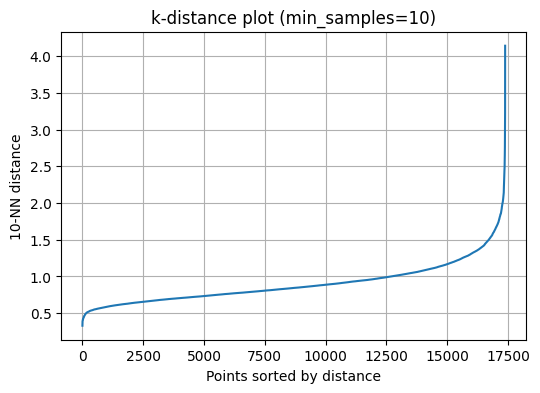

Suggested min_samples = 10
Estimate eps from the 'elbow' in the plot (sharp bend in distance curve).


In [29]:

def dbscan_parameter_suggestion(X, dim_offset=1):
    n_dims = X.shape[1]
    min_samples_suggested = n_dims + dim_offset
    
    # Compute k-nearest neighbor distances
    neigh = NearestNeighbors(n_neighbors=min_samples_suggested)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)
    
    k_distances = np.sort(distances[:, -1])
    
    # Plot k-distance curve
    plt.figure(figsize=(6,4))
    plt.plot(k_distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{min_samples_suggested}-NN distance')
    plt.title(f'k-distance plot (min_samples={min_samples_suggested})')
    plt.grid(True)
    plt.show()
    
    print(f"Suggested min_samples = {min_samples_suggested}")
    print("Estimate eps from the 'elbow' in the plot (sharp bend in distance curve).")
    
    return min_samples_suggested, k_distances

# --- Example usage for Day PCA ---
X_day_db = day_pca_df[[col for col in day_pca_df.columns if 'PC' in col]].values
min_samples_day, k_dist_day = dbscan_parameter_suggestion(X_day_db)

# --- Example usage for Hour PCA ---
X_hr_db = hr_pca_df[[col for col in hr_pca_df.columns if 'PC' in col]].values
min_samples_hr, k_dist_hr = dbscan_parameter_suggestion(X_hr_db)


## DBSCAN

In [30]:
# Day PCA DBSCAN
# Use PCA components only
X_day_db = day_pca_df[[col for col in day_pca_df.columns if 'PC' in col]].values

# DBSCAN parameters
db_day = DBSCAN(eps=2.15, min_samples=9)
day_pca_df['dbscan'] = db_day.fit_predict(X_day_db)

# Count points per cluster
unique, counts = np.unique(day_pca_df['dbscan'], return_counts=True)
print("Day PCA DBSCAN cluster distribution:")
for u, c in zip(unique, counts):
    print(f"  Cluster {u}: {c} points")

Day PCA DBSCAN cluster distribution:
  Cluster -1: 49 points
  Cluster 0: 250 points
  Cluster 1: 47 points
  Cluster 2: 50 points
  Cluster 3: 247 points
  Cluster 4: 41 points
  Cluster 5: 47 points


## Hour PCA DBSCAN

In [31]:
# Use PCA components only
X_hr_db = hr_pca_df[[col for col in hr_pca_df.columns if 'PC' in col]].values

# DBSCAN parameters
db_hr = DBSCAN(eps=1.75, min_samples=10)
hr_pca_df['dbscan'] = db_hr.fit_predict(X_hr_db)

# Count points per cluster
unique, counts = np.unique(hr_pca_df['dbscan'], return_counts=True)
print("Hour PCA DBSCAN cluster distribution:")
for u, c in zip(unique, counts):
    print(f"  Cluster {u}: {c} points")

Hour PCA DBSCAN cluster distribution:
  Cluster -1: 43 points
  Cluster 0: 1263 points
  Cluster 1: 1227 points
  Cluster 2: 5902 points
  Cluster 3: 48 points
  Cluster 4: 23 points
  Cluster 5: 95 points
  Cluster 6: 48 points
  Cluster 7: 22 points
  Cluster 8: 1267 points
  Cluster 9: 66 points
  Cluster 10: 5951 points
  Cluster 11: 1243 points
  Cluster 12: 172 points
  Cluster 13: 9 points


#### Add class along with date

In [32]:
# Adding features dteday, Registered, Casual and hr in respective dataframe

## uncomment to drop columns
# day_pca_df = day_pca_df.drop(columns = ['dteday', 'registered', 'casual'])
# hr_pca_df = hr_pca_df.drop(columns = ['dteday', 'hr', 'registered', 'casual'])

day_pca_df = day_pca_df.merge(day_main[['dteday', 'registered', 'casual']],left_index=True, right_index=True)
day_pca_df.rename(columns={'dteday': 'date'}, inplace=True)

hr_pca_df = hr_pca_df.merge(hour_main[['dteday', 'hr', 'registered', 'casual']],left_index=True, right_index=True)
hr_pca_df.rename(columns={'dteday': 'date'}, inplace=True)

In [33]:
day_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.496486 -1.899065  0.723321  0.057071  0.846668  1.751471 -1.385938   
1  2.852363 -1.432158  0.333588  0.829732  1.521705 -0.478246  0.563957   
2  3.925806  0.047149 -0.566896  0.081312 -0.753215 -1.386389  0.298570   
3  3.411973 -0.582729 -0.123120 -0.063719 -0.534290 -1.243655 -0.925860   
4  3.581714 -0.128729 -0.709095 -0.169393 -0.962252 -0.721033 -0.666030   

        PC8  cluster  dbscan       date  registered  casual  
0 -0.852155        2       1 2011-01-01         654     331  
1 -1.387314        2       2 2011-01-02         670     131  
2  0.220239        2       0 2011-01-03        1229     120  
3  0.296588        2       0 2011-01-04        1454     108  
4  0.420803        2       0 2011-01-05        1518      82

In [34]:
hr_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.147624  0.885872 -1.235789  0.361533  0.419426 -2.377992  1.856502   
1  3.223889  0.898901 -1.163650  0.386578  0.318003 -2.308422  1.824395   
2  3.217620  0.852660 -1.143174  0.392530  0.292461 -2.236443  1.813070   
3  3.143460  0.611694 -1.049890  0.410565  0.246766 -2.190326  1.801716   
4  3.137191  0.565453 -1.029414  0.416517  0.221225 -2.118347  1.790391   

        PC8       PC9  cluster  dbscan       date  hr  registered  casual  
0 -0.316809 -0.759892        4       0 2011-01-01   0          13       3  
1 -0.435059 -0.758851        4       0 2011-01-01   1          32       8  
2 -0.539241 -0.762689        4       0 2011-01-01   2          27       5  
3 -0.620665 -0.756968        4       0 2011-01-01   3          10       3  
4 -0.724846 -0.760806        4       0 2011-01-01   4           1       0

## Clustering based visualization

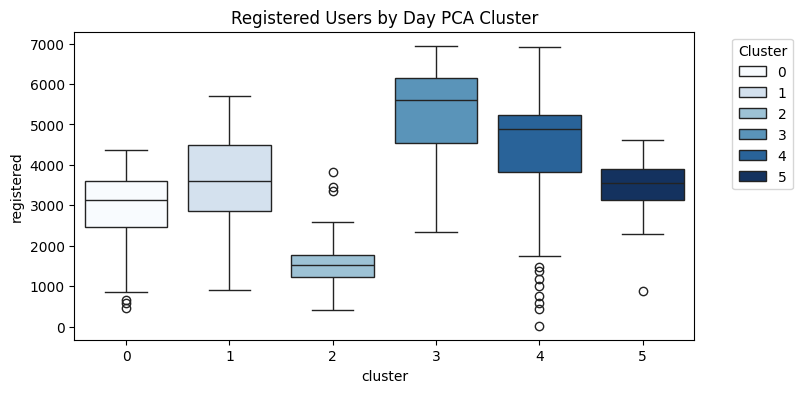

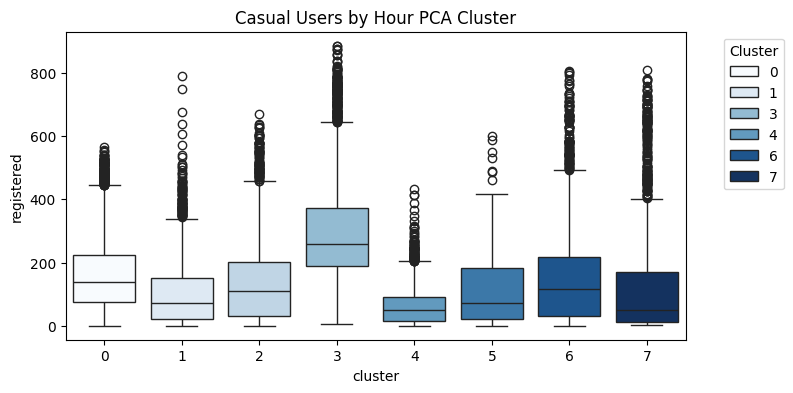

In [35]:
# Boxplots for registered vs clusters
plt.figure(figsize=(8,4))
sns.boxplot(x='cluster', y='registered', hue= 'cluster', data=day_pca_df, palette='Blues', dodge=False)
plt.title('Registered Users by Day PCA Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Boxplots for casual vs clusters
plt.figure(figsize=(8,4))
sns.boxplot(x='cluster', y='registered', hue= 'cluster', data=hr_pca_df, palette='Blues', dodge=False)
plt.title('Casual Users by Hour PCA Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


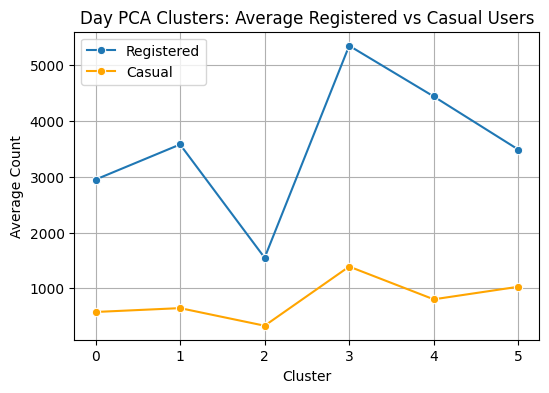

In [36]:
# Aggregate by cluster
day_cluster_avg = day_pca_df.groupby('cluster')[['registered', 'casual']].mean().reset_index()
plt.figure(figsize=(6,4))
sns.lineplot(x='cluster', y='registered', data=day_cluster_avg, marker='o', label='Registered')
sns.lineplot(x='cluster', y='casual', data=day_cluster_avg, marker='o', label='Casual', color='orange')
plt.title('Day PCA Clusters: Average Registered vs Casual Users')
plt.xlabel('Cluster')
plt.ylabel('Average Count')
plt.grid(True)
plt.legend()
plt.show()

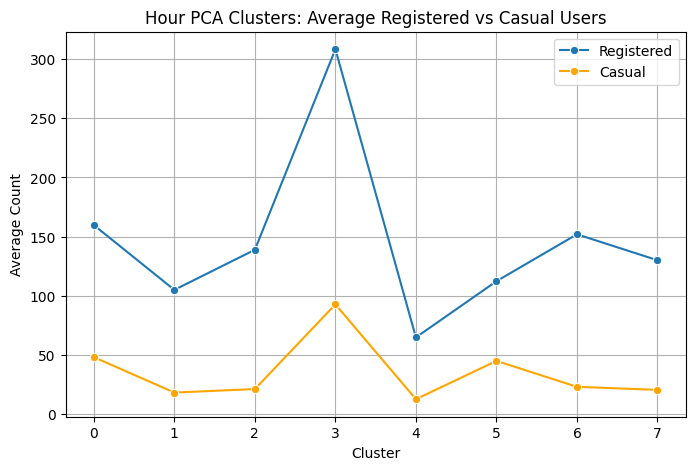

In [37]:
# Aggregate by cluster
hr_cluster_avg = hr_pca_df.groupby('cluster')[['registered', 'casual']].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(x='cluster', y='registered', data=hr_cluster_avg, marker='o', label='Registered')
sns.lineplot(x='cluster', y='casual', data=hr_cluster_avg, marker='o', label='Casual', color='orange')
plt.title('Hour PCA Clusters: Average Registered vs Casual Users')
plt.xlabel('Cluster')
plt.ylabel('Average Count')
plt.grid(True)
plt.legend()
plt.show()

#### Understand PCA Loading

Day Dataset PCA Loadings
- Key observations from loadings:

| PC  | Dominant Features                                                           | Interpretation                                                                                    |
| --- | --------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------- |
| PC1 | season (-0.46), mnth (-0.44), temp (-0.41), atemp (-0.41), windspeed (0.88) | Represents **seasonality, temperature, and wind effects**. Main axis of overall demand variation. |
| PC2 | yr (0.60), date (0.51)                                                      | Captures **year-over-year trend** (2011→2012)                                                     |
| PC3 | weathersit (0.53), hum (0.41), temp/atemp (-0.45)                           | Represents **weather & comfort conditions**                                                       |
| PC4 | holiday (0.60), workingday (-0.59)                                          | Captures **holiday vs working day effect**                                                        |
| PC6 | weekday (0.85)                                                              | Captures **weekly pattern** (weekday influence)                                                   |
| PC7 | windspeed (0.88)                                                            | Strongly dominated by windspeed                                                                   |
| PC8 | holiday (0.72), workingday (0.67)                                           | Another **holiday/workingday combination**                                                        |

For plotting clusters:
- PC1 vs PC3 → main variation by weather & season
- PC2 vs PC4 → trend over year + holiday effects
- PC1 vs PC6 → season + weekday/weekend patterns

Hour Dataset PCA Loadings
- Key observations:

| PC  | Dominant Features                                         | Interpretation                             |
| --- | --------------------------------------------------------- | ------------------------------------------ |
| PC1 | season (-0.46), mnth (-0.44), temp (-0.41), atemp (-0.42) | Overall **season & temperature effect**    |
| PC2 | hum (0.44), temp/atemp (-0.43)                            | Weather variation (humidity & temperature) |
| PC3 | yr (0.62), date (0.46)                                    | **Year-over-year trend**                   |
| PC4 | holiday (0.63), workingday (-0.61)                        | Holiday vs workingday effect               |
| PC6 | weathersit (0.64), hr (0.50)                              | Weather + hour-of-day pattern              |
| PC7 | weekday (0.88)                                            | Day-of-week variation                      |
| PC8 | hr (-0.72), windspeed (0.67)                              | **Hour-of-day & wind effects**             |
| PC9 | holiday (0.71), workingday (0.67)                         | Holiday/workingday effect again            |

For plotting clusters:
- PC1 vs PC2 → season + weather patterns
- PC1 vs PC6 → season + hourly usage pattern
- PC4 vs PC7 → holiday/weekend effect + weekday pattern

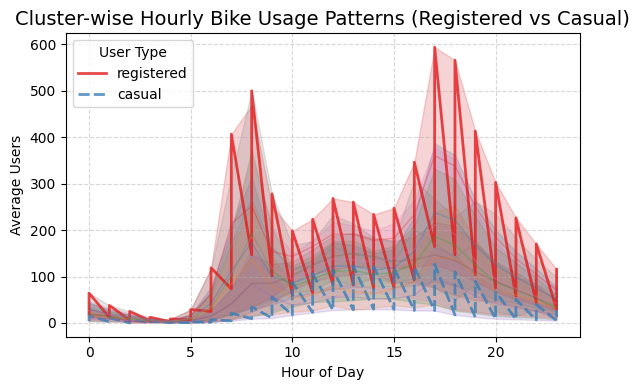

In [38]:
# Calculate mean registered and casual users by cluster and hour
hr_usage_pattern = (hr_pca_df.groupby(['cluster', 'hr'])[['registered', 'casual']].mean().reset_index())
# Melt data for easy plotting with seaborn
hr_melted = hr_usage_pattern.melt(id_vars=['cluster', 'hr'],value_vars=['registered', 'casual'],var_name='user_type',value_name='count')
plt.figure(figsize=(6,4))
sns.lineplot(data=hr_melted,x='hr',y='count',hue='user_type',style='user_type',palette='Set1',estimator=None,linewidth=2,alpha=0.8)
# Overlay cluster patterns as light background lines
sns.lineplot(data=hr_melted,x='hr',y='count',hue='cluster',palette='tab10', linewidth=1,alpha=0.3,legend=False)
plt.title('Cluster-wise Hourly Bike Usage Patterns (Registered vs Casual)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average Users')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='User Type', loc='upper left')
plt.tight_layout()
plt.show()

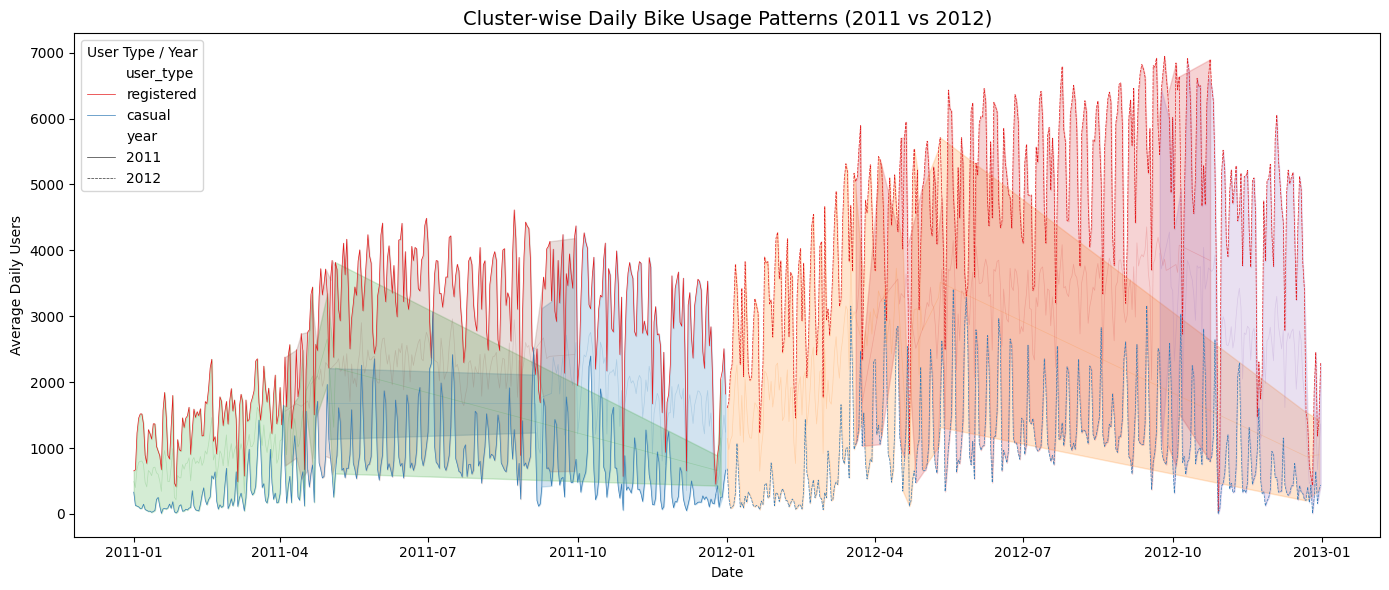

In [39]:
# Extract year for comparison
day_pca_df['year'] = pd.to_datetime(day_pca_df['date']).dt.year

# Aggregate
day_usage_pattern = (
    day_pca_df.groupby(['year', 'cluster', 'date'])[['registered', 'casual']].mean().reset_index())

# Melt for plotting
day_melted = day_usage_pattern.melt(id_vars=['year', 'cluster', 'date'],value_vars=['registered', 'casual'],var_name='user_type',value_name='count')

plt.figure(figsize=(14,6))
# Plot Registered & Casual trends, separated by year
sns.lineplot(data=day_melted,x='date',y='count',hue='user_type',style='year',palette='Set1',linewidth=0.5)
sns.lineplot(data=day_melted,x='date',y='count',hue='cluster',palette='tab10',linewidth=0.5, alpha=0.2,legend=False)
plt.title('Cluster-wise Daily Bike Usage Patterns (2011 vs 2012)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Average Daily Users')
plt.legend(title='User Type / Year', loc='upper left')
plt.tight_layout()
plt.show()


Peak Hour per Cluster:
   cluster  hr  total_users
0        0  17   475.634146
1        1  18   280.756757
2        2   8   385.990826
3        3  17   720.887755
4        4  17   190.955556
5        5  13   298.523810
6        6  17   422.774510
7        7   8   534.366906


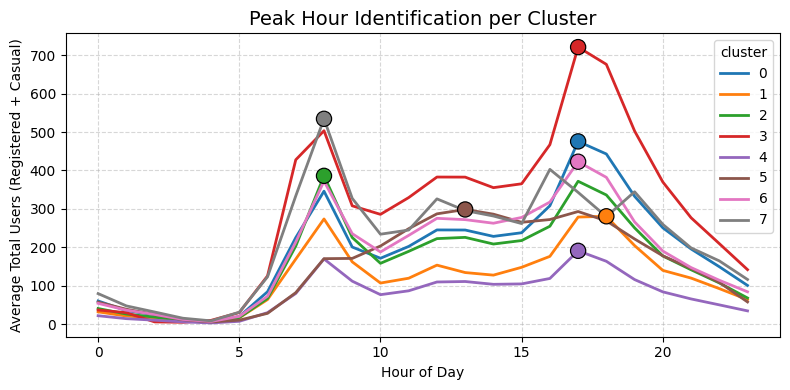

In [40]:
# Ensure we have hour and cluster columns
assert 'hr' in hr_pca_df.columns and 'cluster' in hr_pca_df.columns, "Missing 'hr' or 'cluster' column."
# Calculate mean total users (registered + casual) per cluster-hour
hr_pca_df['total_users'] = hr_pca_df['registered'] + hr_pca_df['casual']
peak_hours = (hr_pca_df.groupby(['cluster', 'hr'])['total_users'].mean().reset_index())
# Identify the peak hour per cluster
peak_hour_summary = (peak_hours.loc[peak_hours.groupby('cluster')['total_users'].idxmax()].sort_values('cluster').reset_index(drop=True))
print("Peak Hour per Cluster:")
print(peak_hour_summary)
# Visualization
plt.figure(figsize=(8,4))
sns.lineplot(data=peak_hours,x='hr',y='total_users',hue='cluster',palette='tab10',linewidth=2)
# Mark the peak hours
sns.scatterplot(data=peak_hour_summary,x='hr',y='total_users',hue='cluster',palette='tab10',s=120,edgecolor='black',legend=False,zorder=5)
plt.title('Peak Hour Identification per Cluster', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average Total Users (Registered + Casual)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

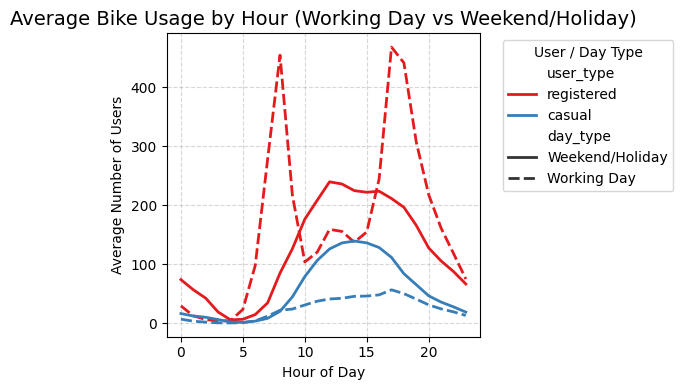

In [41]:
# Make sure we have workingday info
# If not in hr_pca_df, merge it back from hour_main
if 'workingday' not in hr_pca_df.columns:
    hr_pca_df = hr_pca_df.merge(hour_main[['workingday']], left_index=True, right_index=True)

# Calculate total users
hr_pca_df['total_users'] = hr_pca_df['registered'] + hr_pca_df['casual']
# Label type of day
hr_pca_df['day_type'] = hr_pca_df['workingday'].map({1: 'Working Day', 0: 'Weekend/Holiday'})
# Group by hour and day_type
hourly_usage = (hr_pca_df.groupby(['hr', 'day_type'])[['registered', 'casual', 'total_users']].mean().reset_index())
# Melt for plotting
melted_usage = hourly_usage.melt(id_vars=['hr', 'day_type'],value_vars=['registered', 'casual'],var_name='user_type',value_name='count')
# Plot
plt.figure(figsize=(6,4))
sns.lineplot(data=melted_usage,x='hr',y='count',hue='user_type',style='day_type',palette='Set1',linewidth=2)
plt.title('Average Bike Usage by Hour (Working Day vs Weekend/Holiday)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Users')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='User / Day Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
capitalDC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3255670 entries, 0 to 3255672
Data columns (total 7 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Duration              int64         
 1   Start date            datetime64[ns]
 2   End date              datetime64[ns]
 3   Start station number  int64         
 4   End station number    int64         
 5   Bike number           object        
 6   Member type           object        
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 198.7+ MB


In [43]:
capitalDC = capitalDC_main.copy()
capitalDC.head()

Duration          Start date            End date  Start station number  \
0      3548 2011-01-01 00:01:29 2011-01-01 01:00:37                 31620   
1       346 2011-01-01 00:02:46 2011-01-01 00:08:32                 31105   
2       562 2011-01-01 00:06:13 2011-01-01 00:15:36                 31400   
3       434 2011-01-01 00:09:21 2011-01-01 00:16:36                 31111   
4       233 2011-01-01 00:28:26 2011-01-01 00:32:19                 31104   

   End station number Bike number Member type  
0               31620      W00247      Member  
1               31101      W00675      Casual  
2               31104      W00357      Member  
3               31503      W00970      Member  
4               31106      W00346      Casual

In [44]:
# Extract Year, Month, Day
capitalDC['Year'] = capitalDC['Start date'].dt.year
capitalDC['Month'] = capitalDC['Start date'].dt.month
capitalDC['Day'] = capitalDC['Start date'].dt.day
capitalDC['Date'] = capitalDC['Start date'].dt.date

# Aggregate daily summary without FutureWarning
daily_summary = capitalDC.groupby(['Year','Date']).agg(
    RegisteredUser=('Member type', lambda x: (x=='Member').sum()),
    RegisteredUserDuration_hr=('Duration', lambda x: x[capitalDC.loc[x.index,'Member type']=='Member'].sum()/3600),
    CasualUser=('Member type', lambda x: (x=='Casual').sum()),
    CasualUserDuration_hr=('Duration', lambda x: x[capitalDC.loc[x.index,'Member type']=='Casual'].sum()/3600)
).reset_index()

daily_summary.head()

Year        Date  RegisteredUser  RegisteredUserDuration_hr  CasualUser  \
0  2011  2011-01-01             629                 119.901389         330   
1  2011  2011-01-02             651                 110.249444         130   
2  2011  2011-01-03            1181                 214.882222         120   
3  2011  2011-01-04            1429                 285.026111         107   
4  2011  2011-01-05            1489                 259.928611          82   

   CasualUserDuration_hr  
0             283.353056  
1              77.193333  
2             112.081667  
3              59.938889  
4              46.801667

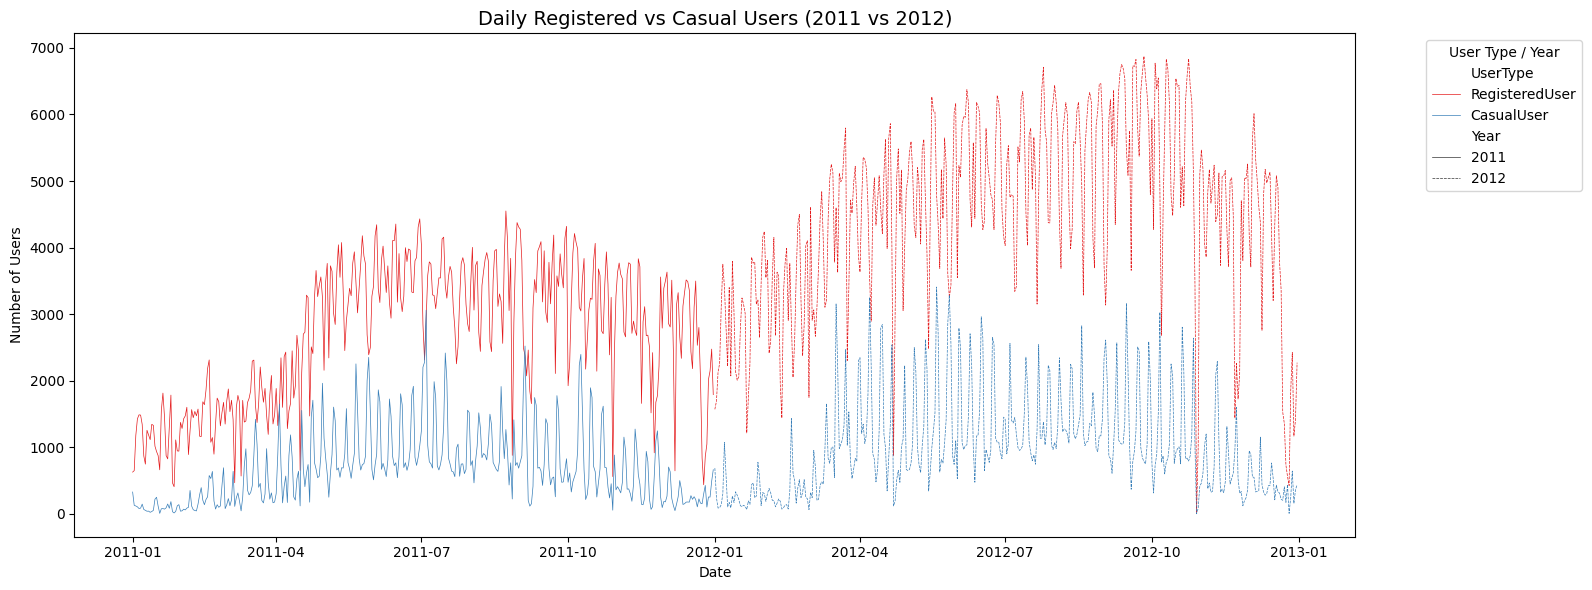

In [45]:
daily_count_melted = daily_summary.melt(id_vars=['Year','Date'],value_vars=['RegisteredUser','CasualUser'],var_name='UserType',value_name='Count')
plt.figure(figsize=(16,6))
sns.lineplot(data=daily_count_melted,x='Date',y='Count',hue='UserType',style='Year',palette='Set1',linewidth=0.5)
plt.title('Daily Registered vs Casual Users (2011 vs 2012)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.legend(title='User Type / Year', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

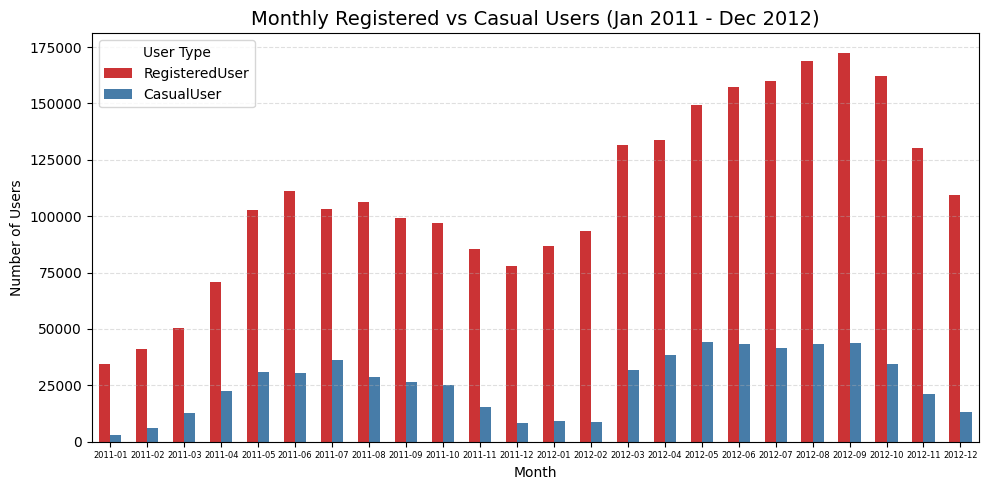

In [46]:
capitalDC['YearMonth'] = pd.to_datetime(capitalDC['Start date'].dt.to_period('M').astype(str))
monthly_summary = capitalDC.groupby('YearMonth').agg(
    RegisteredUser=('Member type', lambda x: (x=='Member').sum()),
    RegisteredUserDuration_hr=('Duration', lambda x: x[capitalDC.loc[x.index,'Member type']=='Member'].sum()/3600),
    CasualUser=('Member type', lambda x: (x=='Casual').sum()),
    CasualUserDuration_hr=('Duration', lambda x: x[capitalDC.loc[x.index,'Member type']=='Casual'].sum()/3600)
).reset_index()
# Melt for plotting counts
monthly_count_melted = monthly_summary.melt(id_vars=['YearMonth'],value_vars=['RegisteredUser','CasualUser'],var_name='UserType',value_name='Count')
# Prepare data
monthly_count_melted['MonthStr'] = monthly_count_melted['YearMonth'].dt.strftime('%Y-%m')
plt.figure(figsize=(10,5))
sns.barplot(data=monthly_count_melted,x='MonthStr',y='Count',hue='UserType',palette='Set1', width=0.6)
plt.title('Monthly Registered vs Casual Users (Jan 2011 - Dec 2012)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.xticks(fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='User Type')
plt.tight_layout()
plt.show()

In [47]:
# Create YearMonth column
capitalDC['YearMonth'] = pd.to_datetime(capitalDC['Start date'].dt.to_period('M').astype(str))

# Aggregate monthly summary with additional features
monthly_est_summary = capitalDC.groupby('YearMonth').agg(
    UniqueStations=('Start station number', lambda x: pd.concat([x, capitalDC.loc[x.index,'End station number']]).nunique()),
    UniqueBikes=('Bike number', 'nunique'),
    RegisteredUser=('Member type', lambda x: (x=='Member').sum()),
    RegisteredUserDuration_hr=('Duration', lambda x: x[capitalDC.loc[x.index,'Member type']=='Member'].sum()/3600),
    CasualUser=('Member type', lambda x: (x=='Casual').sum()),
    CasualUserDuration_hr=('Duration', lambda x: x[capitalDC.loc[x.index,'Member type']=='Casual'].sum()/3600)
).reset_index()

# Display
monthly_est_summary.head(24)

YearMonth  UniqueStations  UniqueBikes  RegisteredUser  \
0  2011-01-01             106          844           34438   
1  2011-02-01             107          892           41326   
2  2011-03-01             106          928           50382   
3  2011-04-01             112          979           70781   
4  2011-05-01             113          988          102789   
5  2011-06-01             115          982          111175   
6  2011-07-01             117          973          103164   
7  2011-08-01             116          956          106222   
8  2011-09-01             117          944           99375   
9  2011-10-01             116          946           96844   
10 2011-11-01             125         1041           85444   
11 2011-12-01             139         1215           77874   
12 2012-01-01             141         1224           86901   
13 2012-02-01             148         1277           93526   
14 2012-03-01             151         1298          131605   
15 2012-04-01             163         1371          134021   
16 2012-05-01             168         1506          149494   
17 2012-06-01             173         1487          157379   
18 2012-07-01             178         1523          159857   
19 2012-08-01             186         1531          168903   
20 2012-09-01             188         1595          172491   
21 2012-10-01             190         1668          162378   
22 2012-11-01             190         1675          130321   
23 2012-12-01             190         1665          109376   

    RegisteredUserDuration_hr  CasualUser  CasualUserDuration_hr  
0                 6368.161111        3065            1819.041111  
1                 7654.071389        6232            4615.892222  
2                10126.358056       12813           10311.510556  
3                16150.965000       22319           19713.329444  
4                25856.911667       30996           25988.721667  
5                25979.132778       30566           22959.900278  
6                22983.057500       36414           28728.425833  
7                23277.061111       28797           22132.612222  
8                21120.095278       26526           19737.799444  
9                20026.221667       25204           18984.949444  
10               17020.505556       15579           10855.356944  
11               14410.664722        8438            5133.071111  
12               16246.188611        8970            5152.920278  
13               17303.823056        8708            5369.318889  
14               26920.361667       31605           23697.741111  
15               27324.335833       38454           28818.793611  
16               31359.557222       44224           31393.825556  
17               32950.222500       43256           28977.571667  
18               31478.890556       41699           27354.856389  
19               32833.668611       43190           28095.890000  
20               35073.881667       43773           29310.089444  
21               31861.021389       34521           22829.205278  
22               24264.435000       21003           12653.816667  
23               19693.529167       13239            7847.560000

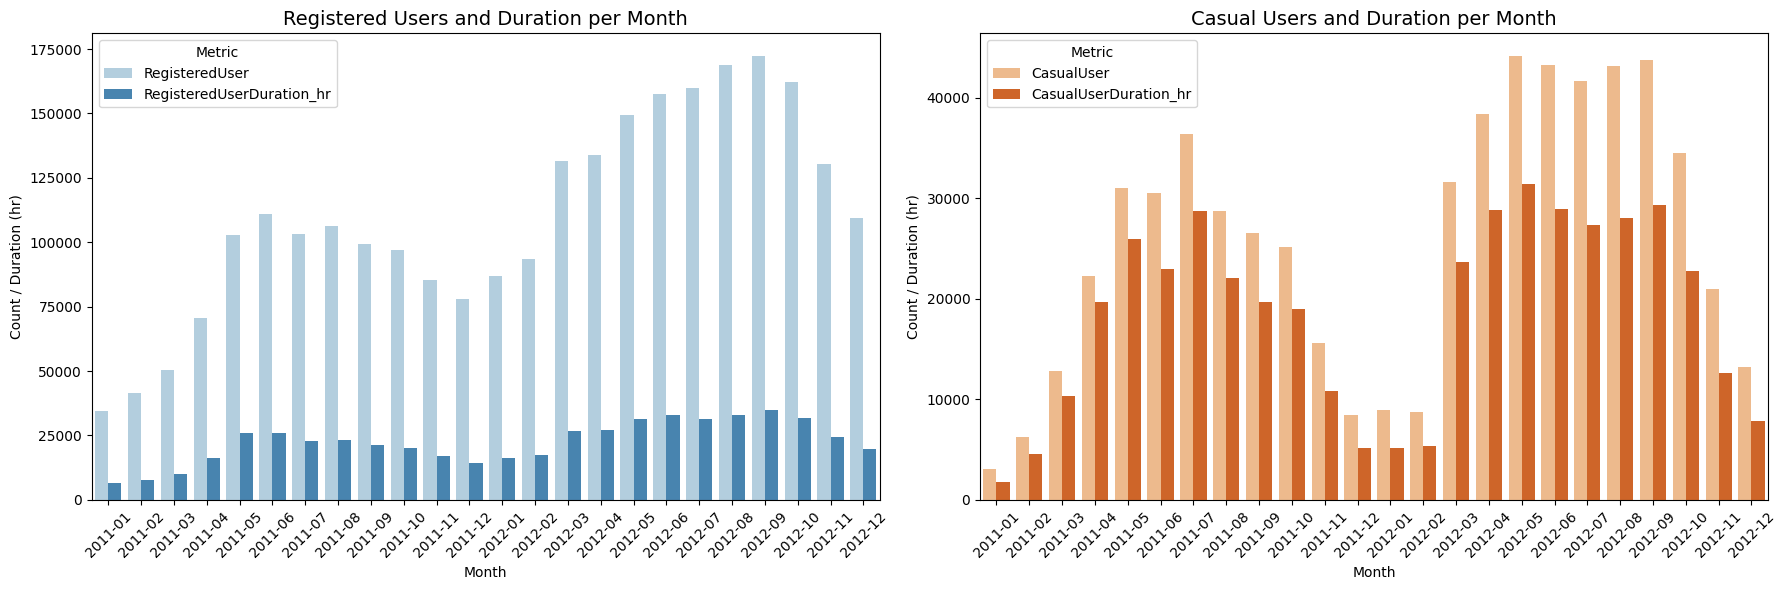

In [48]:
# COmparison of Usertype vs Duration
# Prepare month strings for x-axis
monthly_summary['MonthStr'] = monthly_summary['YearMonth'].dt.strftime('%Y-%m')

# Set figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18,6), sharex=True)

# Registered Users vs Duration
sns.barplot(data=monthly_summary.melt(id_vars=['MonthStr'], 
                              value_vars=['RegisteredUser','RegisteredUserDuration_hr'],
                              var_name='Metric', value_name='Value'),
    x='MonthStr', y='Value', hue='Metric', palette='Blues', ax=axes[0]
)
axes[0].set_title('Registered Users and Duration per Month', fontsize=14)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count / Duration (hr)')
axes[0].tick_params(axis='x', rotation=45)

# Casual Users vs Duration
sns.barplot(
    data=monthly_summary.melt(id_vars=['MonthStr'], 
                              value_vars=['CasualUser','CasualUserDuration_hr'],
                              var_name='Metric', value_name='Value'),
    x='MonthStr', y='Value', hue='Metric', palette='Oranges', ax=axes[1]
)
axes[1].set_title('Casual Users and Duration per Month', fontsize=14)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count / Duration (hr)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

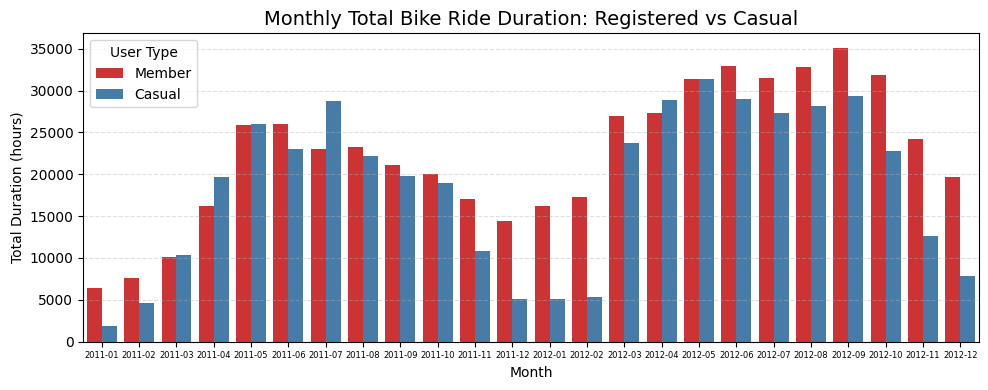

In [49]:
# COmparison of Duration
# Melt durations for easy plotting
duration_melted = monthly_summary.melt(id_vars=['MonthStr'],value_vars=['RegisteredUserDuration_hr','CasualUserDuration_hr'],var_name='UserType', value_name='Duration_hr')

# Map nicer labels
duration_melted['UserType'] = duration_melted['UserType'].map({'RegisteredUserDuration_hr': 'Member','CasualUserDuration_hr': 'Casual'})
plt.figure(figsize=(10,4))
sns.barplot(data=duration_melted, x='MonthStr', y='Duration_hr', hue='UserType', palette='Set1')
plt.title('Monthly Total Bike Ride Duration: Registered vs Casual', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Duration (hours)')
plt.xticks(fontsize=6)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='User Type')
plt.tight_layout()
plt.show()

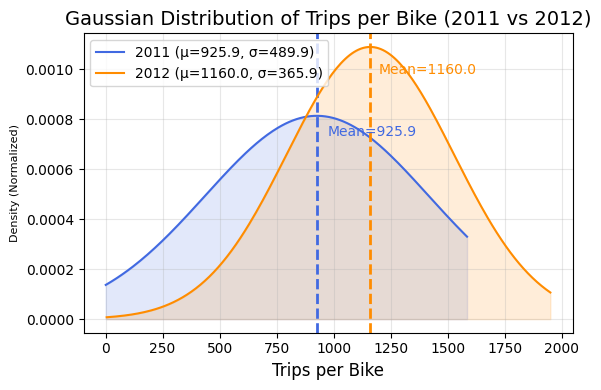

In [50]:
# Extract year
capitalDC['Year'] = capitalDC['Start date'].dt.year
# Count trips per bike per year
trips_per_bike = capitalDC.groupby(['Year', 'Bike number']).size().reset_index(name='Trips')
plt.figure(figsize=(6, 4))
colors = {2011: "royalblue", 2012: "darkorange"}
for year, group in trips_per_bike.groupby('Year'):
    data = group['Trips']
    mean, std = data.mean(), data.std()
    # Gaussian fit
    x = np.linspace(data.min(), data.max(), 200)
    y = norm.pdf(x, mean, std)
    # Plot Gaussian curve
    plt.plot(x, y, color=colors.get(year, 'gray'), label=f"{year} (μ={mean:.1f}, σ={std:.1f})")
    plt.fill_between(x, y, alpha=0.15, color=colors.get(year, 'gray'))
    # Add mean line
    plt.axvline(mean, color=colors.get(year, 'gray'), linestyle='--', linewidth=2)
    plt.text(mean + std*0.1, max(y)*0.9, f"Mean={mean:.1f}", color=colors.get(year, 'gray'))
plt.title("Gaussian Distribution of Trips per Bike (2011 vs 2012)", fontsize=14)
plt.xlabel("Trips per Bike", fontsize=12)
plt.ylabel("Density (Normalized)", fontsize=8)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

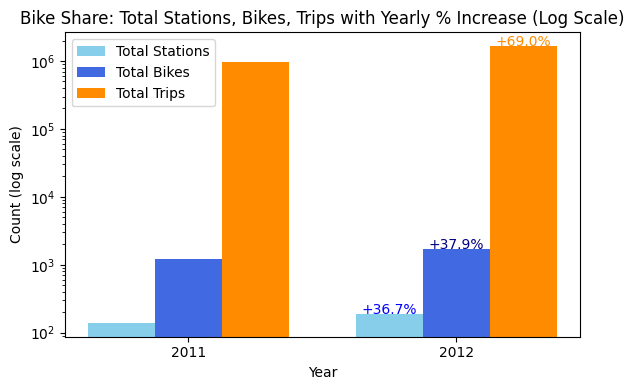

In [51]:
# Aggregate monthly_est_summary to yearly totals
yearly_summary = monthly_est_summary.groupby(monthly_est_summary['YearMonth'].dt.year).agg(
    TotalStations=('UniqueStations', 'max'),
    UniqueBikes=('UniqueBikes', 'max'),
    TotalTrips=('RegisteredUser', 'sum')
).reset_index()
yearly_summary.set_index('YearMonth', inplace=True)

# Prepare values
years = yearly_summary.index.astype(str)
total_stations = yearly_summary['TotalStations']
total_bikes = yearly_summary['UniqueBikes']
total_trips = yearly_summary['TotalTrips']

# Calculate % increase
pct_station = total_stations.pct_change() * 100
pct_bike = total_bikes.pct_change() * 100
pct_trips = total_trips.pct_change() * 100

# X-axis positions
x = np.arange(len(years))
bar_width = 0.25
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.bar(x - bar_width, total_stations, width=bar_width, label='Total Stations', color='skyblue')
ax1.bar(x, total_bikes, width=bar_width, label='Total Bikes', color='royalblue')
ax1.bar(x + bar_width, total_trips, width=bar_width, label='Total Trips', color='darkorange')
ax1.set_xlabel("Year")
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.set_ylabel("Count (log scale)")
ax1.set_yscale('log')
# Add % increase labels (skip first year)
for i in range(1, len(years)):
    ax1.text(x[i] - bar_width, total_stations.iloc[i], f"+{pct_station.iloc[i]:.1f}%", 
             ha='center', color='blue', fontsize=10)
    ax1.text(x[i], total_bikes.iloc[i], f"+{pct_bike.iloc[i]:.1f}%", 
             ha='center', color='navy', fontsize=10)
    ax1.text(x[i] + bar_width, total_trips.iloc[i], f"+{pct_trips.iloc[i]:.1f}%", 
             ha='center', color='darkorange', fontsize=10)
plt.title("Bike Share: Total Stations, Bikes, Trips with Yearly % Increase (Log Scale)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Anomaly Detection

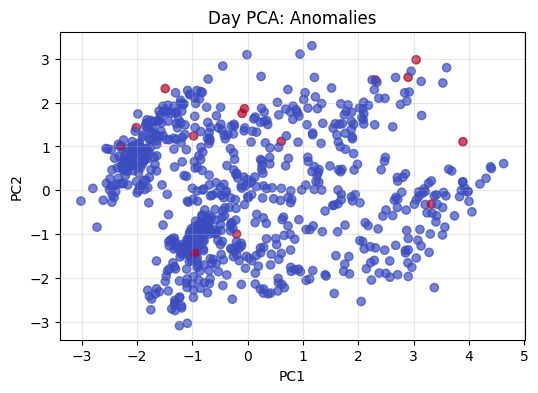

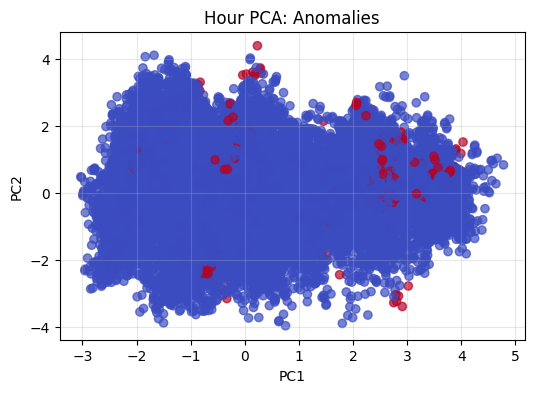

In [52]:
# Isolation forest
def detect_anomalies(df, pca_columns, contamination=0.02, plot_title="Anomaly Detection"):
    iso = IsolationForest(contamination=contamination, random_state=42)
    df['iForest'] = iso.fit_predict(df[pca_columns])
    df['iForest'] = df['iForest'].map({1:0, -1:1})    
    plt.figure(figsize=(6,4))
    plt.scatter(df[pca_columns[0]], df[pca_columns[1]], c=df['iForest'], cmap='coolwarm', alpha=0.7)
    plt.xlabel(pca_columns[0])
    plt.ylabel(pca_columns[1])
    plt.title(plot_title)
    plt.grid(alpha=0.3)
    plt.show()
    return df
day_pca_df = detect_anomalies(day_pca_df, pca_columns=[f'PC{i+1}' for i in range(day_pca_df.filter(like='PC').shape[1])],
                              contamination=0.02, plot_title="Day PCA: Anomalies")
hr_pca_df = detect_anomalies(hr_pca_df, pca_columns=[f'PC{i+1}' for i in range(hr_pca_df.filter(like='PC').shape[1])],
                             contamination=0.02, plot_title="Hour PCA: Anomalies")

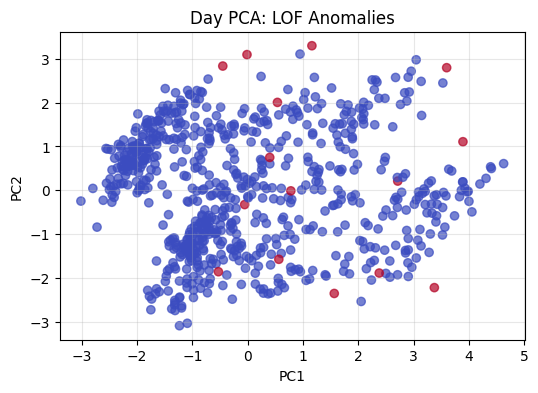

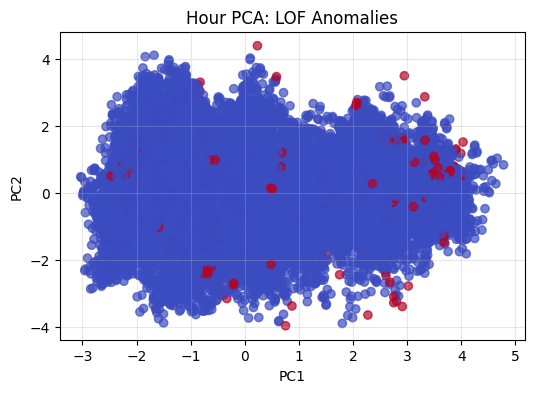

In [53]:
# Local Outlier Factor
def detect_anomalies_lof(df, pca_columns, n_neighbors=20, contamination=0.02, plot_title="LOF Anomaly Detection"):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    df['LOF'] = lof.fit_predict(df[pca_columns])
    df['LOF'] = df['LOF'].map({1:0, -1:1})
    plt.figure(figsize=(6,4))
    plt.scatter(df[pca_columns[0]], df[pca_columns[1]], c=df['LOF'], cmap='coolwarm', alpha=0.7)
    plt.xlabel(pca_columns[0])
    plt.ylabel(pca_columns[1])
    plt.title(plot_title)
    plt.grid(alpha=0.3)
    plt.show()
    return df
day_pca_df = detect_anomalies_lof(day_pca_df, pca_columns=[f'PC{i+1}' for i in range(day_pca_df.filter(like='PC').shape[1])],
                                  n_neighbors=20, contamination=0.02,plot_title="Day PCA: LOF Anomalies")
hr_pca_df = detect_anomalies_lof(hr_pca_df, pca_columns=[f'PC{i+1}' for i in range(hr_pca_df.filter(like='PC').shape[1])],
                                 n_neighbors=700, contamination=0.02, plot_title="Hour PCA: LOF Anomalies")

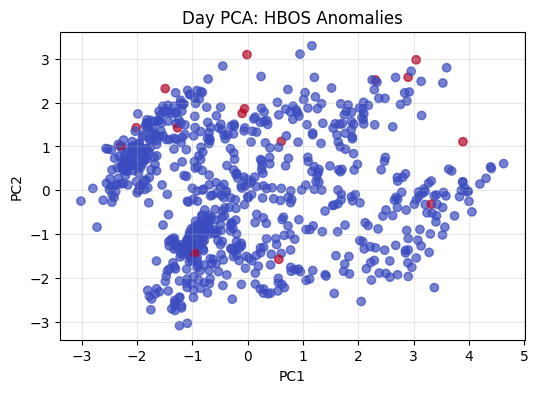

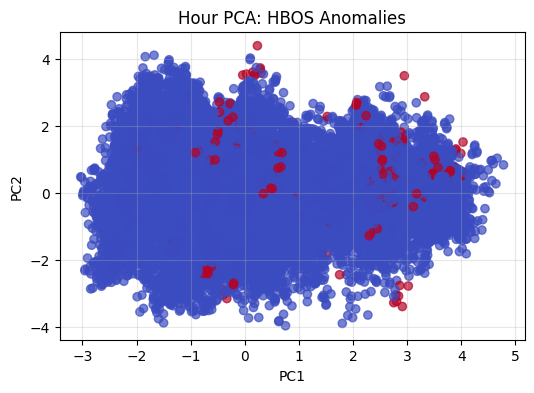

In [54]:
# HBOS
def detect_hbos(df, pca_columns, contamination=0.02, plot_title="HBOS Anomaly Detection"):
    hbos = HBOS(contamination=contamination)
    df['HBOS'] = hbos.fit_predict(df[pca_columns])
    df['HBOS'] = df['HBOS'].map({0:0, 1:1})
    plt.figure(figsize=(6,4))
    plt.scatter(df[pca_columns[0]], df[pca_columns[1]], c=df['HBOS'], cmap='coolwarm', alpha=0.7)
    plt.xlabel(pca_columns[0])
    plt.ylabel(pca_columns[1])
    plt.title(plot_title)
    plt.grid(alpha=0.3)
    plt.show()
    return df
day_pca_df = detect_hbos(day_pca_df, pca_columns=[f'PC{i+1}' for i in range(day_pca_df.filter(like='PC').shape[1])],
                         contamination=0.02, plot_title="Day PCA: HBOS Anomalies")
hr_pca_df = detect_hbos(hr_pca_df, pca_columns=[f'PC{i+1}' for i in range(hr_pca_df.filter(like='PC').shape[1])],
                        contamination=0.02, plot_title="Hour PCA: HBOS Anomalies")

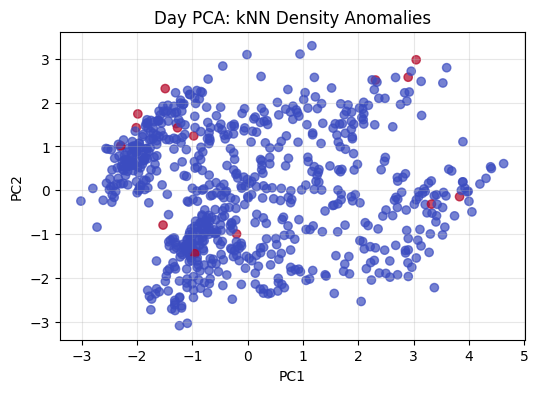

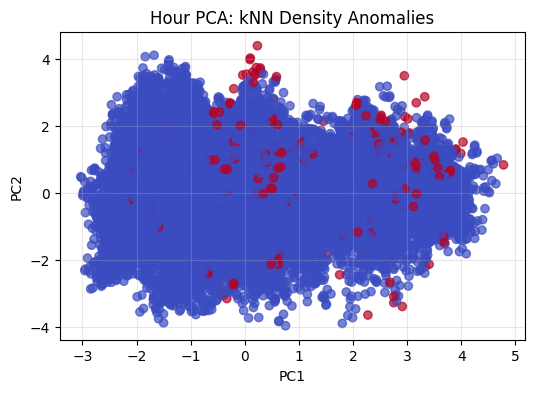

In [55]:
# K-Nearest Neighbour
def detect_knn_density(df, pca_columns, contamination=0.02, n_neighbors=20, plot_title="kNN Density Anomaly Detection"):
    knn = KNN(contamination=contamination, n_neighbors=n_neighbors)
    df['kNN'] = knn.fit_predict(df[pca_columns])
    df['kNN'] = df['kNN'].map({0:0, 1:1})
    plt.figure(figsize=(6,4))
    plt.scatter(df[pca_columns[0]], df[pca_columns[1]], c=df['kNN'], cmap='coolwarm', alpha=0.7)
    plt.xlabel(pca_columns[0])
    plt.ylabel(pca_columns[1])
    plt.title(plot_title)
    plt.grid(alpha=0.3)
    plt.show()
    return df
day_pca_df = detect_knn_density(day_pca_df, pca_columns=[f'PC{i+1}' for i in range(day_pca_df.filter(like='PC').shape[1])],
                                contamination=0.02, n_neighbors=20, plot_title="Day PCA: kNN Density Anomalies")
hr_pca_df = detect_knn_density(hr_pca_df, pca_columns=[f'PC{i+1}' for i in range(hr_pca_df.filter(like='PC').shape[1])],
                               contamination=0.02, n_neighbors=20, plot_title="Hour PCA: kNN Density Anomalies")

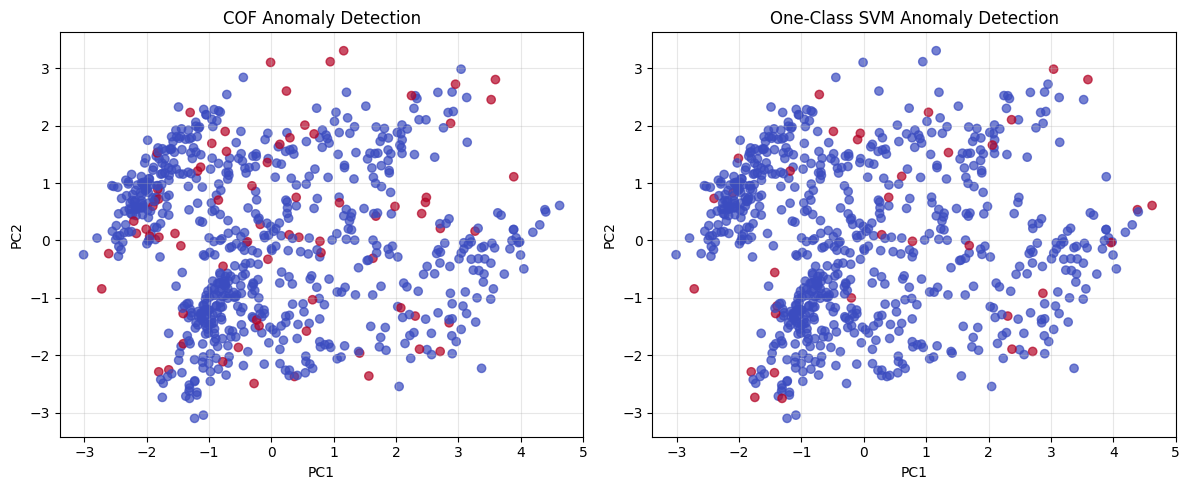

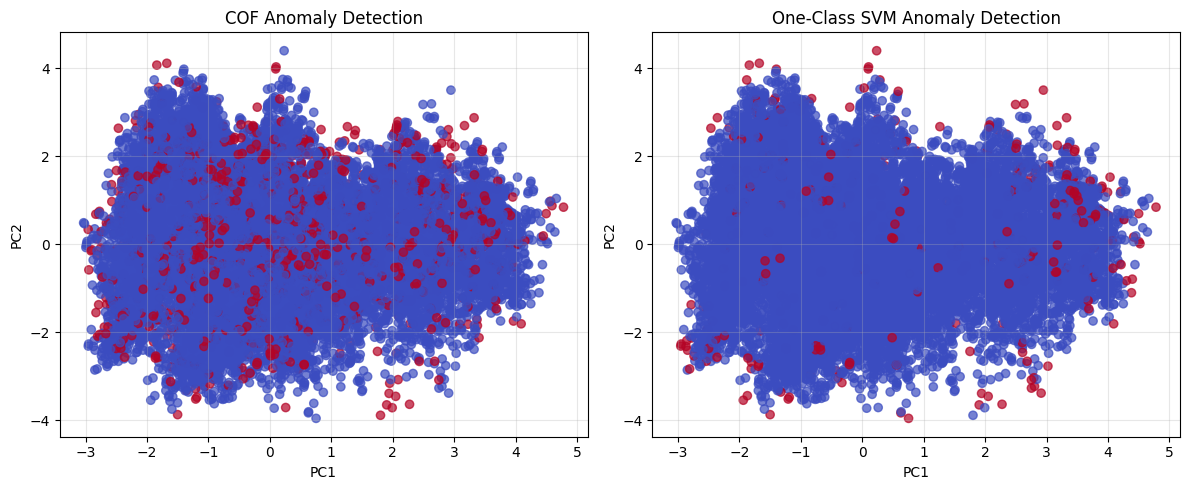

In [56]:
def detect_anomalies_cof_svm(df, pca_columns, contamination=0.02):
    X = df[pca_columns].values
    # --- COF ---
    cof = COF(n_neighbors=20)
    df['COF'] = cof.fit_predict(X)
    df['COF'] = df['COF'].map({0:0, 1:1})
    # --- One-Class SVM ---
    oc_svm = OneClassSVM(nu=contamination, kernel='rbf', gamma='scale')
    df['OCSVM'] = oc_svm.fit_predict(X)
    df['OCSVM'] = df['OCSVM'].map({1:0, -1:1})
    # --- Plot COF anomalies ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(df[pca_columns[0]], df[pca_columns[1]],c=df['COF'], cmap='coolwarm', alpha=0.7)
    plt.xlabel(pca_columns[0])
    plt.ylabel(pca_columns[1])
    plt.title("COF Anomaly Detection")
    plt.grid(alpha=0.3)
    # --- Plot OCSVM anomalies ---
    plt.subplot(1,2,2)
    plt.scatter(df[pca_columns[0]], df[pca_columns[1]],c=df['OCSVM'], cmap='coolwarm', alpha=0.7)
    plt.xlabel(pca_columns[0])
    plt.ylabel(pca_columns[1])
    plt.title("One-Class SVM Anomaly Detection")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    return df
day_pca_df = detect_anomalies_cof_svm(day_pca_df,pca_columns=[f'PC{i+1}' for i in range(day_pca_df.filter(like='PC').shape[1])])
hr_pca_df = detect_anomalies_cof_svm(hr_pca_df,pca_columns=[f'PC{i+1}' for i in range(hr_pca_df.filter(like='PC').shape[1])])

In [59]:
anomaly_cols = ['iForest', 'LOF', 'HBOS', 'kNN', 'COF', 'OCSVM']
anomaly_cols = [col for col in anomaly_cols if col in day_pca_df.columns]
day_pca_df['anomaly_count'] = day_pca_df[anomaly_cols].sum(axis=1)
hr_pca_df['anomaly_count'] = hr_pca_df[anomaly_cols].sum(axis=1)

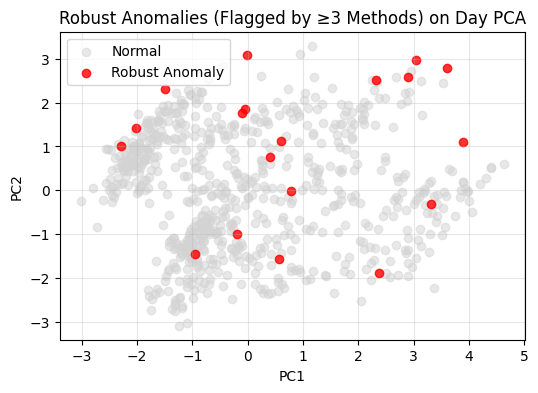

Total points: 731
Robust anomalies: 19


In [60]:
# Separate robust anomalies and normal points flagged by 3 method or more.
robust_anomalies = day_pca_df[day_pca_df['anomaly_count'] >= 3]
normal_points = day_pca_df[day_pca_df['anomaly_count'] < 3]
plt.figure(figsize=(6,4))
# Plot normal points
plt.scatter(normal_points['PC1'], normal_points['PC2'], c='lightgray', alpha=0.5, label='Normal')
# Plot robust anomalies
plt.scatter(robust_anomalies['PC1'], robust_anomalies['PC2'], c='red', alpha=0.8, label='Robust Anomaly')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Robust Anomalies (Flagged by ≥3 Methods) on Day PCA')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
print(f"Total points: {day_pca_df.shape[0]}")
print(f"Robust anomalies: {robust_anomalies.shape[0]}")

### Preparation for Regression Model

In [61]:
day_reg = day_main.copy()
hour_reg= hour_main.copy()

In [62]:
day_reg['year']  = day_reg['dteday'].dt.year
hour_reg['year'] = hour_reg['dteday'].dt.year

In [63]:
# Split data as per year to check whether the model perform well across year
day_train = day_reg[day_reg['year'] == 2011]
day_test  = day_reg[day_reg['year'] == 2012]

hour_train = hour_reg[hour_reg['year'] == 2011]
hour_test  = hour_reg[hour_reg['year'] == 2012]

In [64]:
features_day = day_train.drop(columns=['cnt','registered','casual','dteday'], errors='ignore')
targets_day  = ['registered','casual']

features_hour = hour_train.drop(columns=['cnt','registered','casual','dteday'], errors='ignore')
targets_hour  = ['registered','casual']

In [65]:
# Scale Feature
scaler_day = StandardScaler().fit(features_day)
X_day_train = scaler_day.transform(features_day)
X_day_test  = scaler_day.transform(day_test[features_day.columns])

scaler_hour = StandardScaler().fit(features_hour)
X_hour_train = scaler_hour.transform(features_hour)
X_hour_test  = scaler_hour.transform(hour_test[features_hour.columns])

def train_eval(X_train, y_train, X_test, y_test, targets):
    models = {}
    predictions = {}
    for target in targets:
        lr = LinearRegression()
        lr.fit(X_train, y_train[target])
        y_pred = lr.predict(X_test)
        predictions[target] = y_pred
        models[target] = lr
        print(f"Regression ({target}):")
        print("  R2:", r2_score(y_test[target], y_pred))
        print("  RMSE:", mean_squared_error(y_test[target], y_pred, squared=False))
        print()
    return models, predictions

models_day, predictions_day = train_eval(X_day_train, day_train, X_day_test, day_test, targets_day)
models_hour, predictions_hour = train_eval(X_hour_train, hour_train, X_hour_test, hour_test, targets_hour)

Regression (registered):
  R2: -5.153999351784936
  RMSE: 3528.546111047592

Regression (casual):
  R2: -3.1000526108951085
  RMSE: 1534.7463154518557

Regression (registered):
  R2: -0.0960644062690017
  RMSE: 183.70663829090654

Regression (casual):
  R2: -0.45146263216939264
  RMSE: 68.6321235067483



##### Negative R² values indicate the model is performing worse than a naive mean prediction. The huge RMSE for the day-level registered and casual predictions (thousands) vs. much smaller for hour-level shows that scale and variability differ drastically.

##### Why this happens:
- Non-linear relationships – bike usage depends on season, weather, hour, weekday/weekend, holidays… simple linear regression can’t capture this.
- Different scales – daily counts fluctuate a lot more than hourly aggregated data.
- Missing important features – PCA components might capture some structure, but raw features like weather, working day, holiday, and temperature are very predictive.

#### We will run PCA and try to evaluate the performance for regression

In [66]:
features_day = ['temp','atemp','hum','windspeed','season','yr','mnth','holiday','weekday','workingday','weathersit']
features_hr = features_day + ['hr']

target_vars = ['registered','casual']

# Split 2011 vs 2012
day_reg['year'] = day_reg['dteday'].dt.year
hour_reg['year'] = hour_reg['dteday'].dt.year

train_day = day_reg[day_reg['year']==2011]
test_day  = day_reg[day_reg['year']==2012]

train_hr = hour_reg[hour_reg['year']==2011]
test_hr  = hour_reg[hour_reg['year']==2012]

# Standardize features
scaler_day = StandardScaler()
X_train_day_scaled = scaler_day.fit_transform(train_day[features_day])
X_test_day_scaled  = scaler_day.transform(test_day[features_day])

scaler_hr = StandardScaler()
X_train_hr_scaled = scaler_hr.fit_transform(train_hr[features_hr])
X_test_hr_scaled  = scaler_hr.transform(test_hr[features_hr])

# Apply PCA
pca_day = PCA(n_components=0.95)
X_train_day_pca = pca_day.fit_transform(X_train_day_scaled)
X_test_day_pca  = pca_day.transform(X_test_day_scaled)

pca_hr = PCA(n_components=0.95)
X_train_hr_pca = pca_hr.fit_transform(X_train_hr_scaled)
X_test_hr_pca  = pca_hr.transform(X_test_hr_scaled)

print("Day PCA components:", pca_day.n_components_)
print("Hour PCA components:", pca_hr.n_components_)

for target in target_vars:
    # Day-level
    rf_day = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_day.fit(X_train_day_pca, train_day[target])
    pred_day = rf_day.predict(X_test_day_pca)
    r2_day = r2_score(test_day[target], pred_day)
    rmse_day = np.sqrt(mean_squared_error(test_day[target], pred_day))
    print(f"Day Regression ({target}): R2={r2_day:.3f}, RMSE={rmse_day:.2f}")
    
    # Hour-level
    rf_hr = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_hr.fit(X_train_hr_pca, train_hr[target])
    pred_hr = rf_hr.predict(X_test_hr_pca)
    r2_hr = r2_score(test_hr[target], pred_hr)
    rmse_hr = np.sqrt(mean_squared_error(test_hr[target], pred_hr))
    print(f"Hour Regression ({target}): R2={r2_hr:.3f}, RMSE={rmse_hr:.2f}")


Day PCA components: 7
Hour PCA components: 9
Day Regression (registered): R2=-0.837, RMSE=1927.78
Hour Regression (registered): R2=0.264, RMSE=150.51
Day Regression (casual): R2=0.539, RMSE=514.76
Hour Regression (casual): R2=0.622, RMSE=35.03


R2: -7.296, RMSE: 4096.98


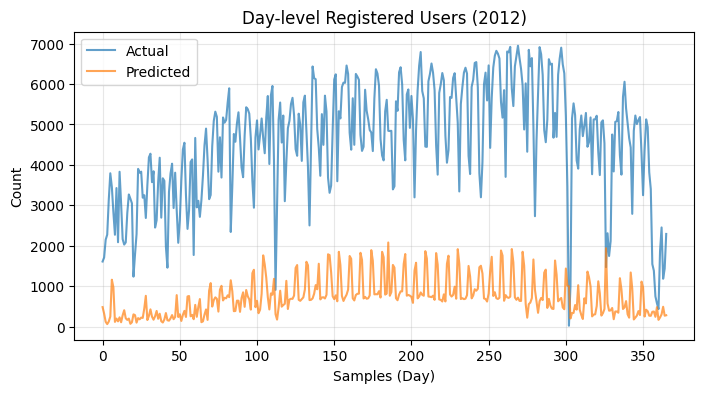

R2: 0.622, RMSE: 35.03


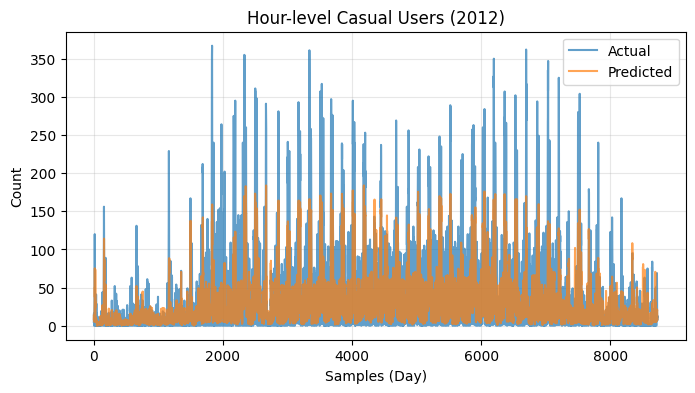

In [67]:
def evaluate_predictions(y_true, y_pred, title="Prediction vs Actual"):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"R2: {r2:.3f}, RMSE: {rmse:.2f}")
    plt.figure(figsize=(8,4))
    plt.plot(y_true.values, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Samples (Day)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

evaluate_predictions(test_day['registered'], rf_day.predict(X_test_day_pca), title="Day-level Registered Users (2012)")
evaluate_predictions(test_hr['casual'], rf_hr.predict(X_test_hr_pca), title="Hour-level Casual Users (2012)")

In [68]:
# There is ahuge fluctuation in actual vs prediction on 2012. Hence we will see the performance in 2011 itself
train_day_2011 = day_reg[day_reg['year']==2011]
train_hr_2011  = hour_reg[hour_reg['year']==2011]

test_day_2012  = day_reg[day_reg['year']==2012]
test_hr_2012   = hour_reg[hour_reg['year']==2012]

train_day, val_day = train_test_split(train_day_2011, test_size=0.3, random_state=42)
train_hr, val_hr   = train_test_split(train_hr_2011, test_size=0.3, random_state=42)

# Standardize features
scaler_day = StandardScaler()
X_train_day_scaled = scaler_day.fit_transform(train_day[features_day])
X_val_day_scaled   = scaler_day.transform(val_day[features_day])
X_test_day_scaled  = scaler_day.transform(test_day_2012[features_day])

scaler_hr = StandardScaler()
X_train_hr_scaled = scaler_hr.fit_transform(train_hr[features_hr])
X_val_hr_scaled   = scaler_hr.transform(val_hr[features_hr])
X_test_hr_scaled  = scaler_hr.transform(test_hr_2012[features_hr])


# Apply PCA (retain 95% variance)
pca_day = PCA(n_components=0.95)
X_train_day_pca = pca_day.fit_transform(X_train_day_scaled)
X_val_day_pca   = pca_day.transform(X_val_day_scaled)
X_test_day_pca  = pca_day.transform(X_test_day_scaled)

pca_hr = PCA(n_components=0.95)
X_train_hr_pca = pca_hr.fit_transform(X_train_hr_scaled)
X_val_hr_pca   = pca_hr.transform(X_val_hr_scaled)
X_test_hr_pca  = pca_hr.transform(X_test_hr_scaled)

print("Day PCA components:", pca_day.n_components_)
print("Hour PCA components:", pca_hr.n_components_)

# 6. Train Random Forest and evaluate
for target in target_vars:
    # --- Day-level ---
    rf_day = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_day.fit(X_train_day_pca, train_day[target])
    
    # Validation
    pred_val_day = rf_day.predict(X_val_day_pca)
    r2_val_day = r2_score(val_day[target], pred_val_day)
    rmse_val_day = np.sqrt(mean_squared_error(val_day[target], pred_val_day))
    
    # Test on 2012
    pred_test_day = rf_day.predict(X_test_day_pca)
    r2_test_day = r2_score(test_day_2012[target], pred_test_day)
    rmse_test_day = np.sqrt(mean_squared_error(test_day_2012[target], pred_test_day))
    
    print(f"\nDay Regression ({target}):")
    print(f"Validation 2011 R2={r2_val_day:.3f}, RMSE={rmse_val_day:.2f}")
    print(f"Test 2012 R2={r2_test_day:.3f}, RMSE={rmse_test_day:.2f}")
    
    # --- Hour-level ---
    rf_hr = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_hr.fit(X_train_hr_pca, train_hr[target])
    
    # Validation
    pred_val_hr = rf_hr.predict(X_val_hr_pca)
    r2_val_hr = r2_score(val_hr[target], pred_val_hr)
    rmse_val_hr = np.sqrt(mean_squared_error(val_hr[target], pred_val_hr))
    
    # Test on 2012
    pred_test_hr = rf_hr.predict(X_test_hr_pca)
    r2_test_hr = r2_score(test_hr_2012[target], pred_test_hr)
    rmse_test_hr = np.sqrt(mean_squared_error(test_hr_2012[target], pred_test_hr))
    
    print(f"\nHour Regression ({target}):")
    print(f"Validation 2011 R2={r2_val_hr:.3f}, RMSE={rmse_val_hr:.2f}")
    print(f"Test 2012 R2={r2_test_hr:.3f}, RMSE={rmse_test_hr:.2f}")

Day PCA components: 7
Hour PCA components: 9

Day Regression (registered):
Validation 2011 R2=0.731, RMSE=555.93
Test 2012 R2=-0.847, RMSE=1933.00

Hour Regression (registered):
Validation 2011 R2=0.562, RMSE=73.21
Test 2012 R2=0.248, RMSE=152.21

Day Regression (casual):
Validation 2011 R2=0.765, RMSE=273.36
Test 2012 R2=0.496, RMSE=537.97

Hour Regression (casual):
Validation 2011 R2=0.810, RMSE=17.48
Test 2012 R2=0.607, RMSE=35.69


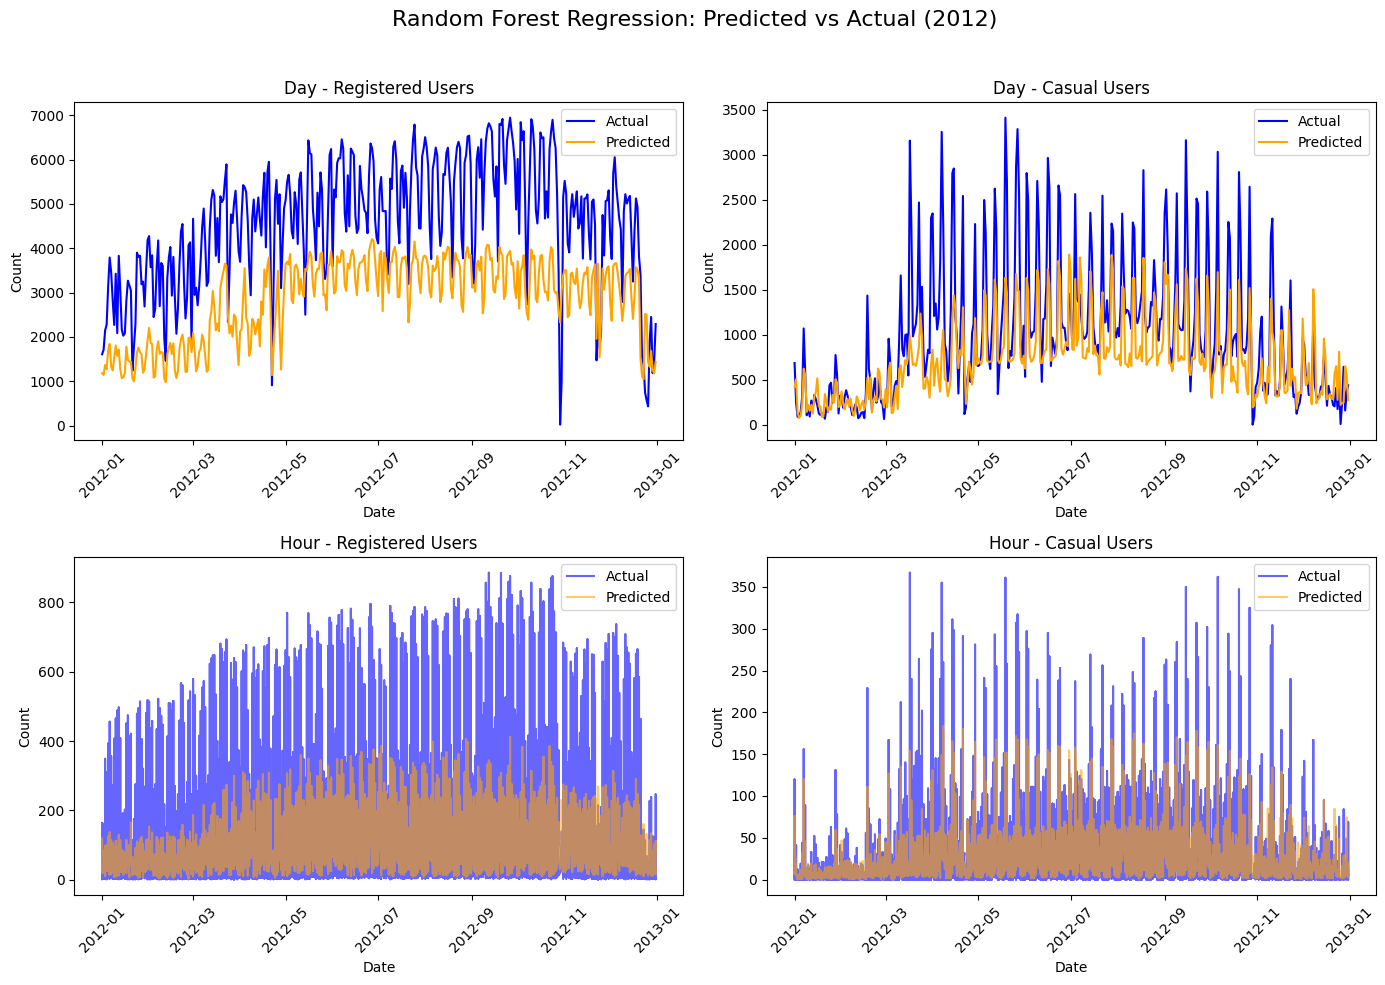

In [69]:
# Prepare predictions for plotting
predictions = {}

for target in target_vars:
    # Day-level
    rf_day = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_day.fit(X_train_day_pca, train_day[target])
    pred_test_day = rf_day.predict(X_test_day_pca)
    
    # Hour-level
    rf_hr = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_hr.fit(X_train_hr_pca, train_hr[target])
    pred_test_hr = rf_hr.predict(X_test_hr_pca)
    
    predictions[target] = {
        'day': pred_test_day,
        'hour': pred_test_hr
    }
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('Random Forest Regression: Predicted vs Actual (2012)', fontsize=16)

# Day - Registered
axes[0,0].plot(test_day_2012['dteday'], test_day_2012['registered'], label='Actual', color='blue')
axes[0,0].plot(test_day_2012['dteday'], predictions['registered']['day'], label='Predicted', color='orange')
axes[0,0].set_title('Day - Registered Users')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Count')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Day - Casual
axes[0,1].plot(test_day_2012['dteday'], test_day_2012['casual'], label='Actual', color='blue')
axes[0,1].plot(test_day_2012['dteday'], predictions['casual']['day'], label='Predicted', color='orange')
axes[0,1].set_title('Day - Casual Users')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Count')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# Hour - Registered
axes[1,0].plot(test_hr_2012['dteday'], test_hr_2012['registered'], label='Actual', color='blue', alpha=0.6)
axes[1,0].plot(test_hr_2012['dteday'], predictions['registered']['hour'], label='Predicted', color='orange', alpha=0.6)
axes[1,0].set_title('Hour - Registered Users')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Count')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Hour - Casual
axes[1,1].plot(test_hr_2012['dteday'], test_hr_2012['casual'], label='Actual', color='blue', alpha=0.6)
axes[1,1].plot(test_hr_2012['dteday'], predictions['casual']['hour'], label='Predicted', color='orange', alpha=0.6)
axes[1,1].set_title('Hour - Casual Users')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Count')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [70]:
# Aggregate capitalDC to day-level
capital_day = capitalDC.copy()
capital_day['Date'] = capital_day['Start date'].dt.date
day_features = capital_day.groupby('Date').agg(
    UniqueStations=('Start station number', lambda x: pd.concat([x, capital_day.loc[x.index,'End station number']]).nunique()),
    UniqueBikes=('Bike number', 'nunique')
).reset_index()
# Prepare day-level regression dataset
day_reg['Date'] = day_reg['dteday'].dt.date
# Merge
day_merged = day_reg.merge(day_features, on='Date', how='left')
# Check the resulting dataframe
print(day_merged.head())

   instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1        0        6           0   
1        2 2011-01-02       1   0     1        0        0           0   
2        3 2011-01-03       1   0     1        0        1           1   
3        4 2011-01-04       1   0     1        0        2           1   
4        5 2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  year        Date  UniqueStations  UniqueBikes  
0   985  2011  2011-01-01          

In [71]:
day_merged = day_merged.drop(columns = 'cnt')

In [72]:
# Optional: Prepare features and target
features_day = ['temp','atemp','hum','windspeed','season','yr','mnth','holiday','weekday','workingday','weathersit',
                'UniqueStations','UniqueBikes']
target_vars = ['registered','casual']

# Split 2011 vs 2012
day_merged['year'] = pd.to_datetime(day_merged['dteday']).dt.year
train_day = day_merged[day_merged['year']==2011]
test_day  = day_merged[day_merged['year']==2012]

# Standardize
from sklearn.preprocessing import StandardScaler
scaler_day = StandardScaler()
X_train_day_scaled = scaler_day.fit_transform(train_day[features_day])
X_test_day_scaled  = scaler_day.transform(test_day[features_day])

# Apply PCA
from sklearn.decomposition import PCA
pca_day = PCA(n_components=0.95)
X_train_day_pca = pca_day.fit_transform(X_train_day_scaled)
X_test_day_pca  = pca_day.transform(X_test_day_scaled)

print("Day PCA components:", pca_day.n_components_)

for target in target_vars:
    rf_day = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_day.fit(X_train_day_pca, train_day[target])
    pred_day = rf_day.predict(X_test_day_pca)
    r2_day = r2_score(test_day[target], pred_day)
    rmse_day = np.sqrt(mean_squared_error(test_day[target], pred_day))
    print(f"Day Regression ({target}): R2={r2_day:.3f}, RMSE={rmse_day:.2f}")

Day PCA components: 8
Day Regression (registered): R2=-1.395, RMSE=2201.45
Day Regression (casual): R2=-0.031, RMSE=769.55


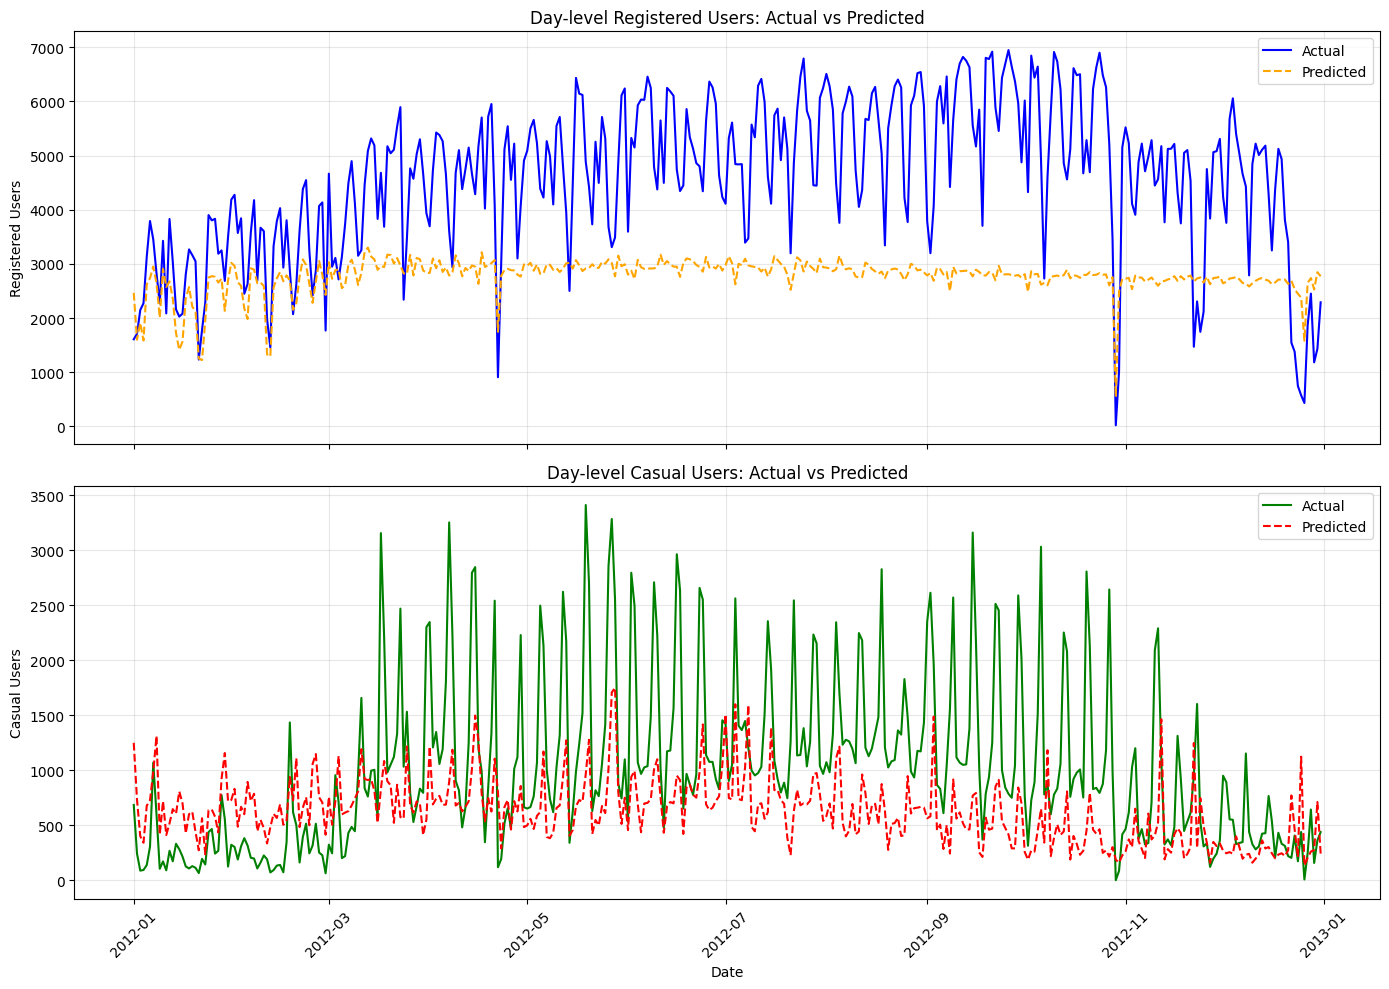

In [73]:
# Predict both targets
predictions = {}
for target in target_vars:
    rf_day = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_day.fit(X_train_day_pca, train_day[target])
    predictions[target] = rf_day.predict(X_test_day_pca)

# Prepare figure
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Registered users
axes[0].plot(test_day['dteday'], test_day['registered'], label='Actual', color='blue')
axes[0].plot(test_day['dteday'], predictions['registered'], label='Predicted', color='orange', linestyle='--')
axes[0].set_ylabel('Registered Users')
axes[0].set_title('Day-level Registered Users: Actual vs Predicted')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Casual users
axes[1].plot(test_day['dteday'], test_day['casual'], label='Actual', color='green')
axes[1].plot(test_day['dteday'], predictions['casual'], label='Predicted', color='red', linestyle='--')
axes[1].set_ylabel('Casual Users')
axes[1].set_xlabel('Date')
axes[1].set_title('Day-level Casual Users: Actual vs Predicted')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
# Compute correlation with target columns
corr_matrix = day_merged[features_day + target_vars].corr()
corr_registered = corr_matrix['registered'].sort_values(ascending=False)
corr_casual = corr_matrix['casual'].sort_values(ascending=False)

print("Top features correlated with REGISTERED:")
print(corr_registered.head(10))
print("\nTop features correlated with CASUAL:")
print(corr_casual.head(10))

Top features correlated with REGISTERED:
registered        1.000000
UniqueBikes       0.906496
UniqueStations    0.733579
yr                0.594248
atemp             0.544192
temp              0.540012
season            0.411623
casual            0.395282
workingday        0.303907
mnth              0.293488
Name: registered, dtype: float64

Top features correlated with CASUAL:
casual            1.000000
atemp             0.543864
temp              0.543285
UniqueBikes       0.475989
registered        0.395282
UniqueStations    0.322162
yr                0.248546
season            0.210399
mnth              0.123006
weekday           0.059923
Name: casual, dtype: float64


Top 10 features for REGISTERED:
           Feature  Importance
13     UniqueBikes    0.857070
5       workingday    0.055558
8            atemp    0.020426
7             temp    0.017804
12  UniqueStations    0.011806
9              hum    0.010793
2             mnth    0.009400
10       windspeed    0.008197
6       weathersit    0.003431
4          weekday    0.003068

Top 10 features for CASUAL:
           Feature  Importance
5       workingday    0.351050
7             temp    0.203119
8            atemp    0.169077
13     UniqueBikes    0.158766
9              hum    0.031915
12  UniqueStations    0.022410
10       windspeed    0.021328
4          weekday    0.016509
2             mnth    0.014839
6       weathersit    0.005092


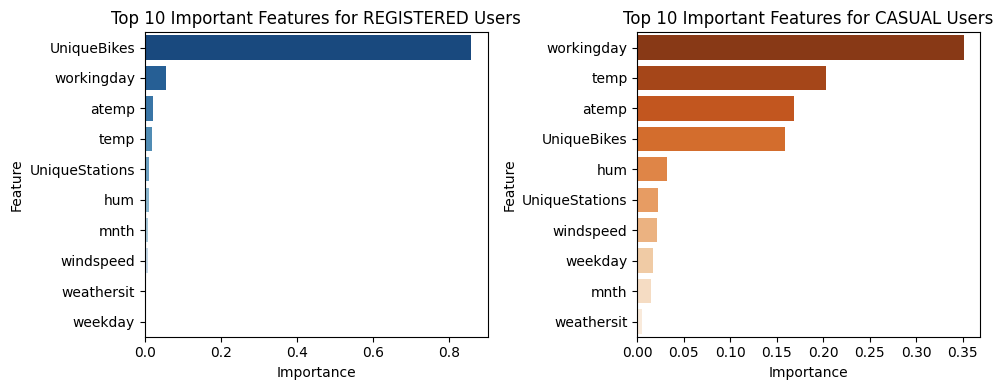

In [76]:
# --- Prepare data ---
X = day_merged.drop(columns=['registered', 'casual','instant'], errors='ignore')
X = X.select_dtypes(include=[np.number])  # keep only numeric columns
y_registered = day_merged['registered']
y_casual = day_merged['casual']

# --- Train random forests ---
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X, y_registered)
rf_cas = RandomForestRegressor(n_estimators=200, random_state=42)
rf_cas.fit(X, y_casual)

# --- Feature importance ---
importances_registered = pd.DataFrame({'Feature': X.columns,'Importance': rf_reg.feature_importances_}).sort_values('Importance', ascending=False)
importances_casual = pd.DataFrame({'Feature': X.columns,'Importance': rf_cas.feature_importances_}).sort_values('Importance', ascending=False)

print("Top 10 features for REGISTERED:")
print(importances_registered.head(10))
print("\nTop 10 features for CASUAL:")
print(importances_casual.head(10))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=importances_registered.head(10), ax=axes[0], palette='Blues_r')
axes[0].set_title("Top 10 Important Features for REGISTERED Users")
sns.barplot(x='Importance', y='Feature', data=importances_casual.head(10), ax=axes[1], palette='Oranges_r')
axes[1].set_title("Top 10 Important Features for CASUAL Users")
plt.tight_layout()
plt.show()


#### Time Series Analysis

In [77]:
# Drop instant feature as dteday will be the index

day = day_main.copy()
hour= hour_main.copy()

day = day.drop(columns = 'instant')
hour = hour.drop(columns = 'instant')

day = day.sort_values('dteday')
hour = hour.sort_values(['dteday', 'hr'])

day.set_index('dteday', inplace=True)
hour['datetime'] = hour['dteday'] + pd.to_timedelta(hour['hr'], unit='h')
hour.set_index('datetime', inplace=True)

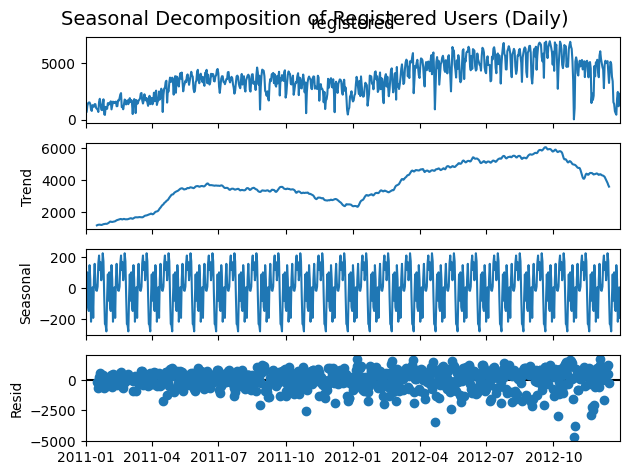

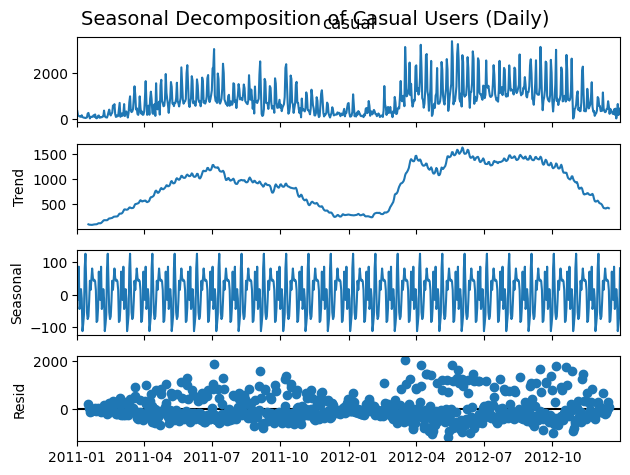

In [78]:
result = seasonal_decompose(day['registered'], model='additive', period=30)  # 30 days = monthly seasonality
result.plot()
plt.suptitle('Seasonal Decomposition of Registered Users (Daily)', fontsize=14)
plt.show()
result_casual = seasonal_decompose(day['casual'], model='additive', period=30)
result_casual.plot()
plt.suptitle('Seasonal Decomposition of Casual Users (Daily)', fontsize=14)
plt.show()


--- Autoregression for registered ---
RMSE: 1451.23


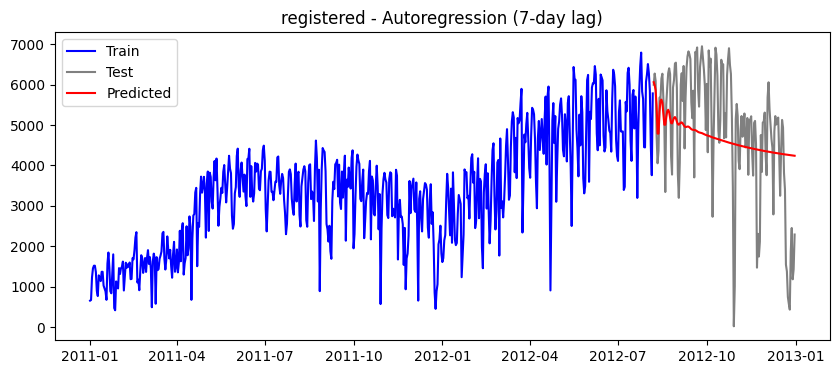


--- Autoregression for casual ---
RMSE: 634.70


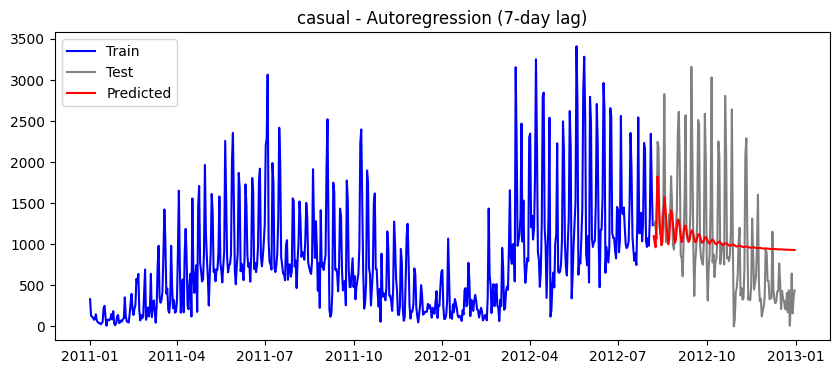

In [79]:
# Autoregression & Moving Average on day dataset
day.index.freq = 'D'
for col in ['registered', 'casual']:
    print(f"\n--- Autoregression for {col} ---")
    # Train-test split (80%-20%)
    split = int(0.8 * len(day))
    train, test = day[col].iloc[:split], day[col].iloc[split:]
    
    # Fit AR model
    model = AutoReg(train, lags=7)
    model_fit = model.fit()
    
    # Predict on test set
    predictions = model_fit.predict(start=len(train), end=len(day)-1, dynamic=False)
    
    # Evaluate performance
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f'RMSE: {rmse:.2f}')
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='gray')
    plt.plot(test.index, predictions, label='Predicted', color='red')
    plt.title(f'{col} - Autoregression (7-day lag)')
    plt.legend()
    plt.show()


--- Moving Average for registered ---


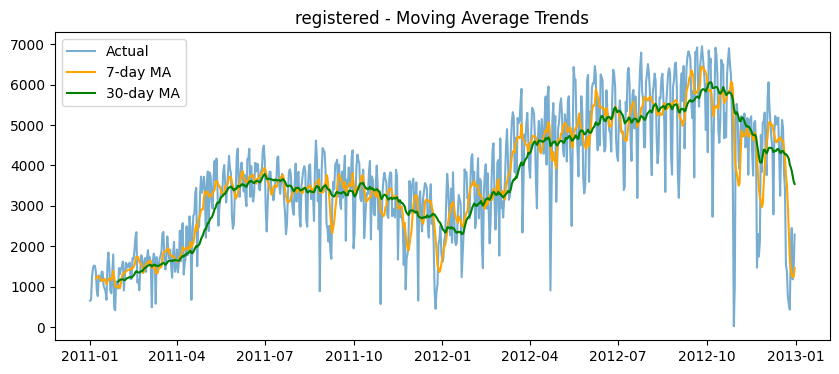


--- Moving Average for casual ---


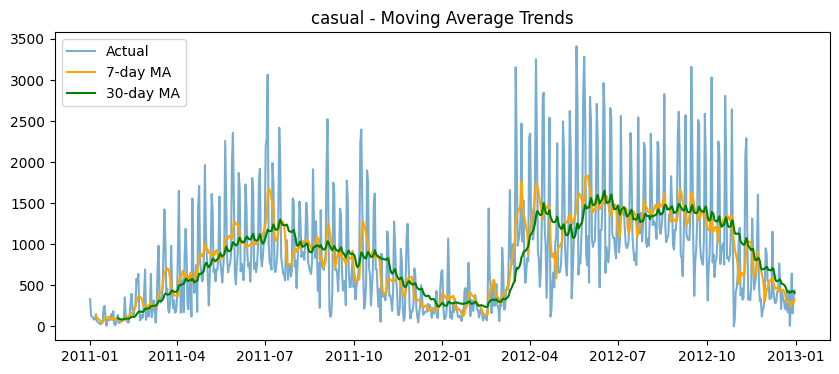

In [80]:
# Moving Average
for col in ['registered', 'casual']:
    print(f"\n--- Moving Average for {col} ---")
    plt.figure(figsize=(10,4))
    plt.plot(day[col], label='Actual', alpha=0.6)
    plt.plot(day[col].rolling(7).mean(), label='7-day MA', color='orange')
    plt.plot(day[col].rolling(30).mean(), label='30-day MA', color='green')
    plt.title(f'{col} - Moving Average Trends')
    plt.legend()
    plt.show()

registered - Simple MA Forecast RMSE: 1708.15
casual - Simple MA Forecast RMSE: 796.39


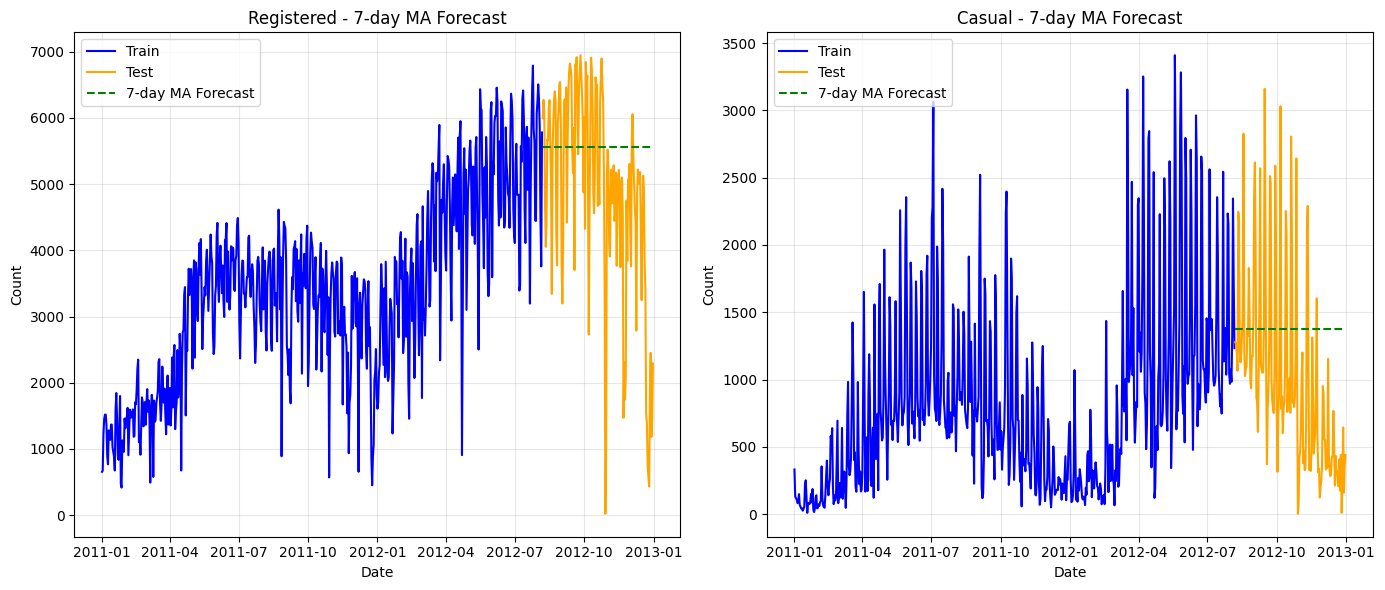

In [81]:
# Simple Moving average
plt.figure(figsize=(14,6))
for i, col in enumerate(['registered', 'casual'], 1):
    split = int(0.8 * len(day))
    train, test = day[col].iloc[:split], day[col].iloc[split:]
    # 7-day moving average forecast
    pred_ma = train.tail(7).mean()
    forecast = np.full(len(test), pred_ma)
     # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f'{col} - Simple MA Forecast RMSE: {rmse:.2f}')

    # Plot
    plt.subplot(1,2,i)
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, forecast, label='7-day MA Forecast', color='green', linestyle='--')
    plt.title(f'{col.capitalize()} - 7-day MA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

registered - ARIMA RMSE: 1644.86
casual - ARIMA RMSE: 769.22


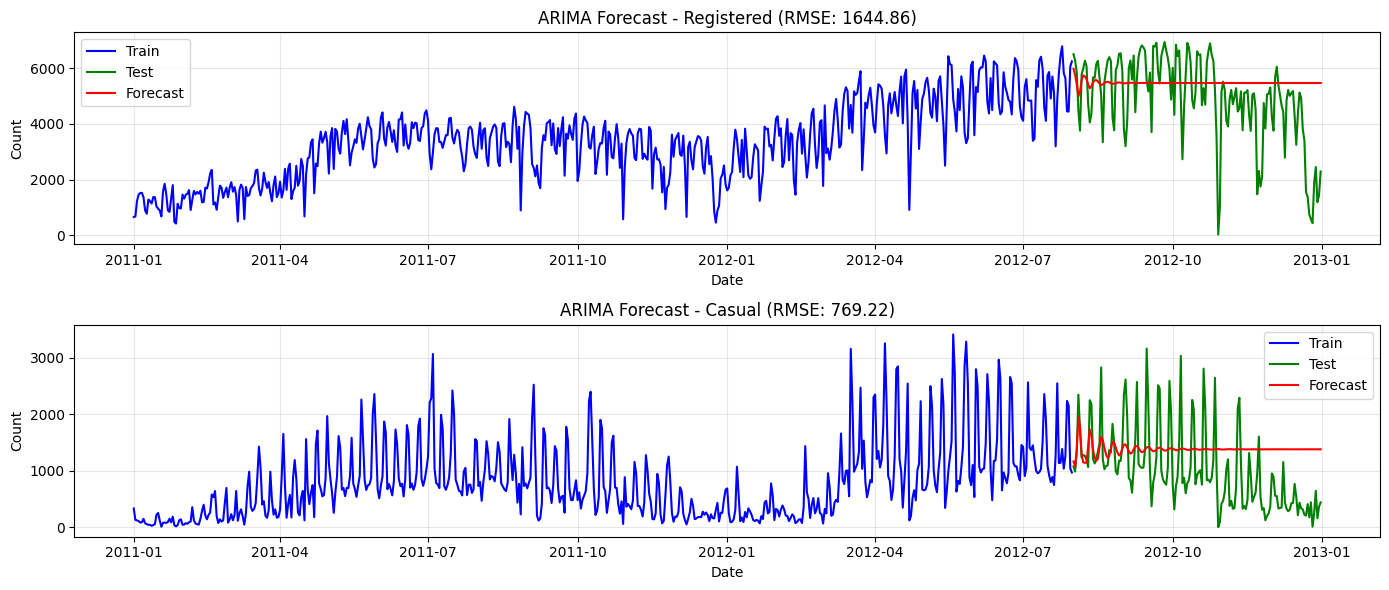

In [82]:
# ARIMA
cols = ['registered', 'casual']
# Split train/test (2011 vs 2012)
train_end = '2012-07-31'
test_start = '2012-08-01'
plt.figure(figsize=(14,6))
for i, col in enumerate(cols, 1):
    y_train = day.loc[:train_end, col]
    y_test = day.loc[test_start:, col]
    # Fit ARIMA - order can be tuned with ACF/PACF or auto_arima
    model = ARIMA(y_train, order=(7,1,2))
    model_fit = model.fit()
    # Forecast for test period
    forecast = model_fit.forecast(steps=len(y_test))
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    print(f'{col} - ARIMA RMSE: {rmse:.2f}')
    # Plot train, test, forecast
    plt.subplot(2,1,i)
    plt.plot(y_train.index, y_train, label='Train', color='blue')
    plt.plot(y_test.index, y_test, label='Test', color='green')
    plt.plot(y_test.index, forecast, label='Forecast', color='red')
    plt.title(f'ARIMA Forecast - {col.capitalize()} (RMSE: {rmse:.2f})')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [83]:
import pmdarima as pm

train_series = day['registered'][:'2012-07-31']
auto_model = pm.auto_arima(
    train_series,
    seasonal=False,        # True if you want SARIMA with seasonality
    stepwise=True,         # Faster search
    trace=True,            # Print progress
    suppress_warnings=True
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9206.926, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9400.880, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9384.697, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9312.256, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9398.959, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9220.978, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9213.868, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9233.333, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9218.198, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9210.575, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9210.483, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9208.617, Time=0.18 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] interc

c:\Users\basud\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


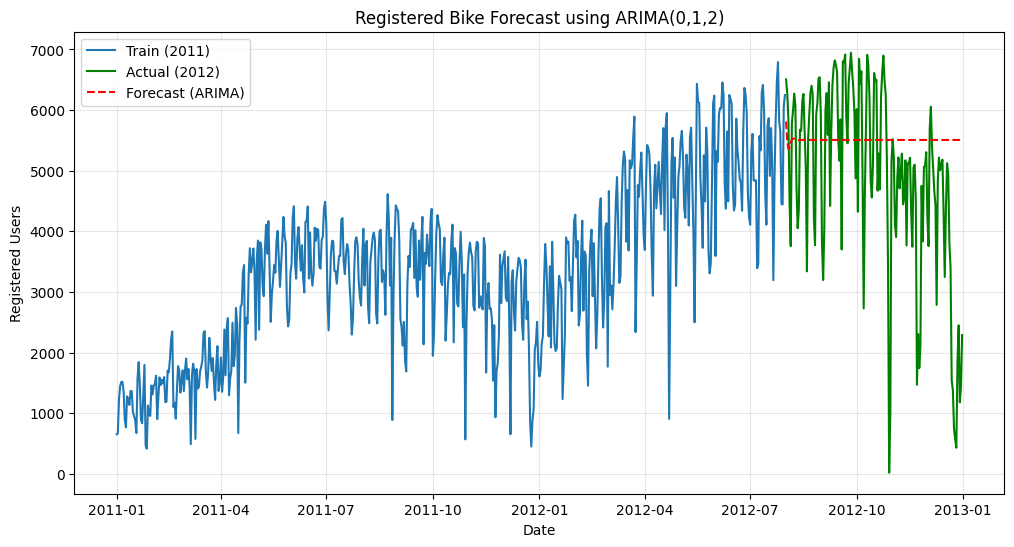

ARIMA Forecast RMSE: 1666.41


In [84]:
# Training series
train = day['registered'][:'2012-07-31']
test  = day['registered']['2012-08-01':]
# Fit ARIMA(0,1,2)
model = ARIMA(train, order=(2,1,2))
fit = model.fit()
# Forecast
forecast = fit.forecast(len(test))
# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train (2011)')
plt.plot(test.index, test, label='Actual (2012)', color='green')
plt.plot(test.index, forecast, label='Forecast (ARIMA)', color='red', linestyle='--')
plt.title('Registered Bike Forecast using ARIMA(0,1,2)')
plt.xlabel('Date')
plt.ylabel('Registered Users')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA Forecast RMSE: {rmse:.2f}')

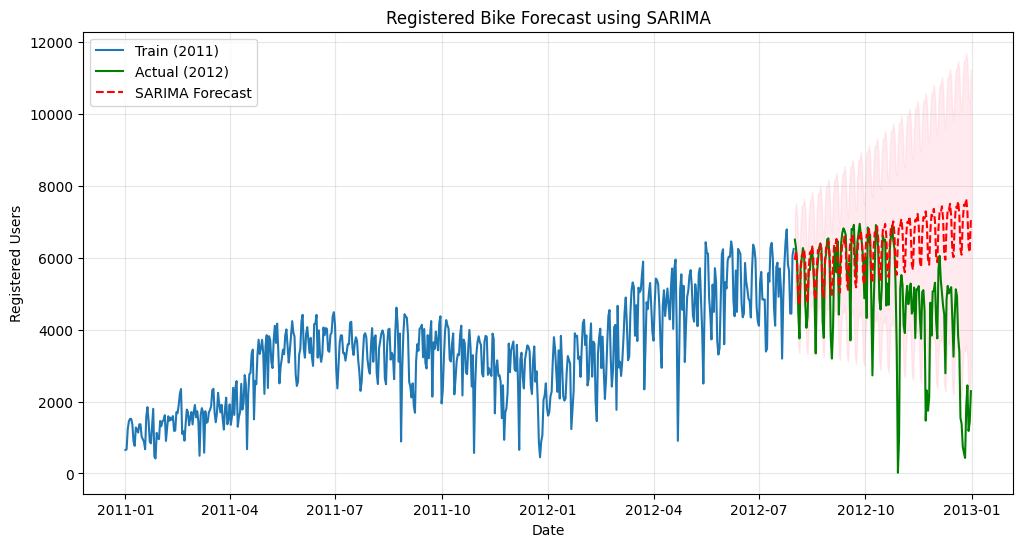

In [85]:
train = day['registered'][:'2012-07-31']
test  = day['registered']['2012-08-01':]
# Fit SARIMA with weekly seasonality
sarima_model = SARIMAX(train, order=(0,1,2), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit(disp=False)
# Forecast
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train (2011)')
plt.plot(test.index, test, label='Actual (2012)', color='green')
plt.plot(test.index, forecast_mean, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(test.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title('Registered Bike Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Registered Users')
plt.legend()
plt.grid(alpha=0.3)
plt.show()